#Import Libraries

In [1]:
pip install handyspark

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType, TimestampType

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()


RuntimeError: Java gateway process exited before sending its port number

#Drive Mount and Read Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Define the schema for the dataset
schema = StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("vendor_id", StringType(), True),
    StructField("rate_code", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_time_in_secs", IntegerType(), True),
    StructField("trip_distance", FloatType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True)
])

In [5]:
df1 = spark.read.csv('/content/gdrive/MyDrive/Data Analysis/trip_data_12.csv',header=True, schema=schema)
df1.show(5,0)

+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|medallion                       |hack_license                    |vendor_id|rate_code|store_and_fwd_flag|pickup_datetime    |dropoff_datetime   |passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|D7D598CD99978BD012A87A76A7C891B7|82F90D5EFE52FDFD2FDEC3EAD6D5771D|VTS      |1        |NULL              |2013-12-01 00:13:00|2013-12-01 00:31:00|1              |1080             |3.9          |-73.97934       |

In [6]:
from pyspark.sql.functions import col

# Extract date from pickup_datetime and create a new 'date' column
df1 = df1.withColumn('date', col('pickup_datetime').cast('date'))

# Use sample with fraction for PySpark DataFrames
before_christmas = df1.filter(df1['date'] < '2013-12-24').sample(fraction=0.01)  # 0.01 fraction before Christmas
during_christmas = df1.filter((df1['date'] >= '2013-12-24') & (df1['date'] <= '2013-12-31')).sample(fraction=0.02)  # 0.02 fraction during Christmas

# Now you have two separate DataFrames:
df_1 = before_christmas
df_2 = during_christmas

#Data Cleaning

In [7]:
from pyspark.sql.functions import col, count, when

# Inspect the dataset
df_1.printSchema()
df_1.describe().show()

# Check for missing values
missing_values = df_1.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_1.columns
])
missing_values.show()

# Drop rows with any null values (optional, based on your needs)
df_cleaned = df_1.dropna()

# Show the cleaned data
df_cleaned.show(5)

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- date: date (nullable = true)

+-------+--------------------+--------------------+---------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|           medallion|        hack_license|vendor_id|          rate_

In [8]:
df_cleaned.count()

54200

In [9]:
df = df_cleaned

#Feature Engineering

Distance Between Pickup and Dropoff Points

In [13]:
from pyspark.sql.functions import hour, dayofmonth, month, dayofweek, col, unix_timestamp, radians, sin, cos, sqrt, atan2, when

# Extract additional features from pickup_datetime
df = df.withColumn("pickup_hour", hour(col("pickup_datetime"))) \
       .withColumn("pickup_day", dayofmonth(col("pickup_datetime"))) \
       .withColumn("pickup_month", month(col("pickup_datetime"))) \
       .withColumn("pickup_day_of_week", dayofweek(col("pickup_datetime")))

# Calculate trip duration in minutes
df = df.withColumn("trip_duration", (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)

# Calculate Haversine distance
R = 6371.0
df = df.withColumn("pickup_latitude_rad", radians(col("pickup_latitude"))) \
       .withColumn("pickup_longitude_rad", radians(col("pickup_longitude"))) \
       .withColumn("dropoff_latitude_rad", radians(col("dropoff_latitude"))) \
       .withColumn("dropoff_longitude_rad", radians(col("dropoff_longitude"))) \
       .withColumn("lat_diff", col("dropoff_latitude_rad") - col("pickup_latitude_rad")) \
       .withColumn("lon_diff", col("dropoff_longitude_rad") - col("pickup_longitude_rad")) \
       .withColumn("a", sin(col("lat_diff") / 2) ** 2 + cos(col("pickup_latitude_rad")) * cos(col("dropoff_latitude_rad")) * sin(col("lon_diff") / 2) ** 2) \
       .withColumn("c", 2 * atan2(sqrt(col("a")), sqrt(1 - col("a")))) \
       .withColumn("haversine_distance", col("c") * R) \
       .drop("pickup_latitude_rad", "pickup_longitude_rad", "dropoff_latitude_rad", "dropoff_longitude_rad", "lat_diff", "lon_diff", "a", "c")

# Create rush hour and weekend indicators
df = df.withColumn("is_rush_hour", when((col("pickup_hour").between(7, 9)) | (col("pickup_hour").between(16, 19)), 1).otherwise(0)) \
       .withColumn("is_weekend", when(col("pickup_day_of_week").isin([7, 1]), 1).otherwise(0))

# Calculate trip speed in km/h
df = df.withColumn("trip_speed_kmph", (col("haversine_distance") / (col("trip_duration") / 60)).cast("double"))

# Create time of day categories
df = df.withColumn("time_of_day",
                   when(col("pickup_hour").between(5, 11), "morning")
                   .when(col("pickup_hour").between(12, 16), "afternoon")
                   .when(col("pickup_hour").between(17, 21), "evening")
                   .otherwise("night"))

# Create distance per passenger feature
df = df.withColumn("distance_per_passenger", (col("haversine_distance") / col("passenger_count")).cast("double"))

# Show dataframe with new features
df.show(5)


+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+----------+------------------+-----------+----------+------------+------------------+------------------+------------+----------+------------------+-----------+----------------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|      date|haversine_distance|pickup_hour|pickup_day|pickup_month|pickup_day_of_week|     trip_duration|is_rush_hour|is_weekend|   trip_speed_kmph|time_of_day|distance_per_passenger|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+--

In [11]:
df.show(5)


+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+----------+------------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|      date|haversine_distance|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+----------+------------------+
|214DFEA924058D63E...|BE2A54E64846E15CE...|      CMT|        1|                 N|2013-12-23 01:05:10|2013-12-23 01:11:49|              2|              398|          1.8|      -73.990753|      

Rush Hour Indicator:

In [ ]:
# from pyspark.sql.functions import hour, dayofmonth, month, dayofweek, col, unix_timestamp

# # Extract additional features from pickup_datetime
# df = df.withColumn("pickup_hour", hour(col("pickup_datetime")))
# df = df.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))
# df = df.withColumn("pickup_month", month(col("pickup_datetime")))
# df = df.withColumn("pickup_day_of_week", dayofweek(col("pickup_datetime")))

# # Calculate trip duration in minutes
# df = df.withColumn("trip_duration",
#                    (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)

# # Show the dataframe with new features
# df.show(5)


+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+----------+-----------+----------+------------+------------------+------------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|      date|pickup_hour|pickup_day|pickup_month|pickup_day_of_week|     trip_duration|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+----------+-----------+----------+------------+------------------+------------------+
|7BB584EB81171917E...|1A5A51

In [14]:
# Summary statistics for categorical features
categorical_features = ['vendor_id', 'rate_code', 'store_and_fwd_flag', 'is_rush_hour', 'is_weekend', 'time_of_day']
for feature in categorical_features:
    df.groupBy(feature).count().orderBy("count", ascending=False).show()


+---------+-----+
|vendor_id|count|
+---------+-----+
|      CMT|54200|
+---------+-----+

+---------+-----+
|rate_code|count|
+---------+-----+
|        1|52943|
|        2|  958|
|        5|  161|
|        3|   99|
|        4|   19|
|        0|   17|
|        6|    3|
+---------+-----+

+------------------+-----+
|store_and_fwd_flag|count|
+------------------+-----+
|                 N|53266|
|                 Y|  934|
+------------------+-----+

+------------+-----+
|is_rush_hour|count|
+------------+-----+
|           0|36575|
|           1|17625|
+------------+-----+

+----------+-----+
|is_weekend|count|
+----------+-----+
|         0|37904|
|         1|16296|
+----------+-----+

+-----------+-----+
|time_of_day|count|
+-----------+-----+
|    evening|14813|
|    morning|14218|
|      night|12595|
|  afternoon|12574|
+-----------+-----+



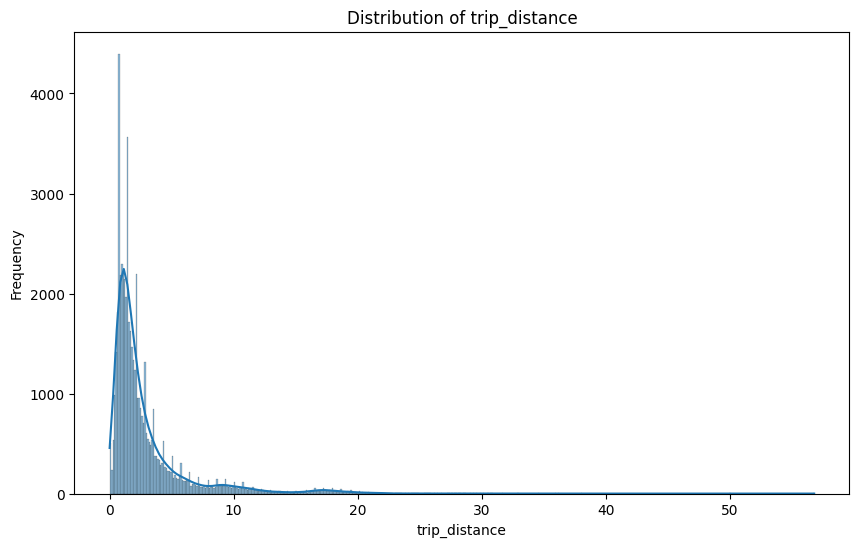

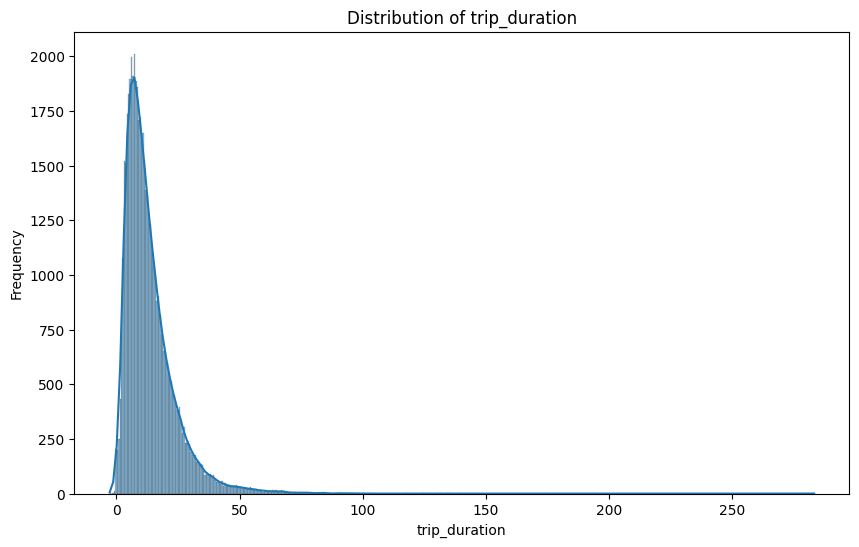

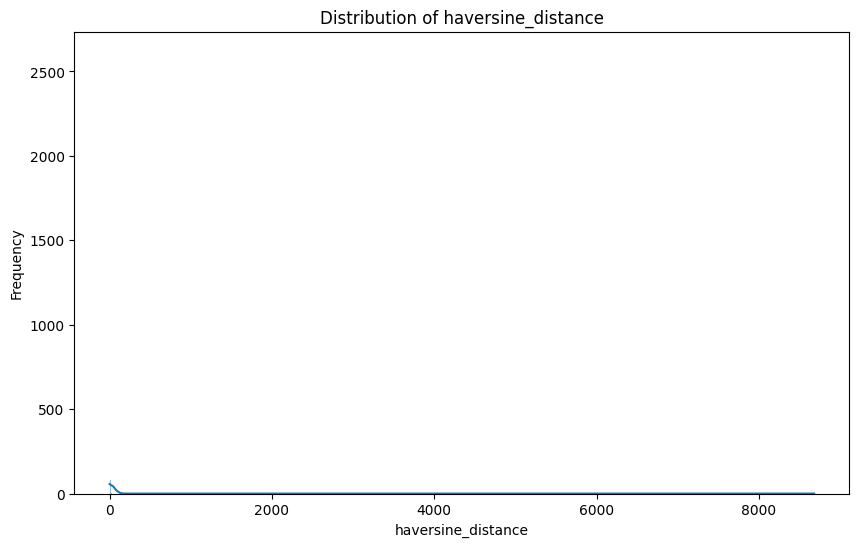

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for plotting
df_pd = df.toPandas()

# Numerical features to plot
numerical_features = ['trip_distance', 'trip_duration', 'haversine_distance',
                      'trip_speed_kmph', 'distance_per_passenger', 'pickup_hour',
                      'pickup_day', 'pickup_month']

# Distribution plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_pd[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Categorical features to plot
categorical_features = ['vendor_id', 'rate_code', 'store_and_fwd_flag',
                        'is_rush_hour', 'is_weekend', 'time_of_day']

# Count plots for categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df_pd[feature])
    plt.title(f'Count plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas if not already done
df_pd = df.toPandas()

# Select the best numerical features for correlation analysis
selected_features = ['trip_distance', 'trip_duration', 'haversine_distance',
                     'trip_speed_kmph', 'distance_per_passenger', 'pickup_hour',
                     'pickup_day', 'pickup_month']

# Compute the correlation matrix
correlation_matrix = df_pd[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features')
plt.show()


NameError: name 'df' is not defined

#Univariate Analysis

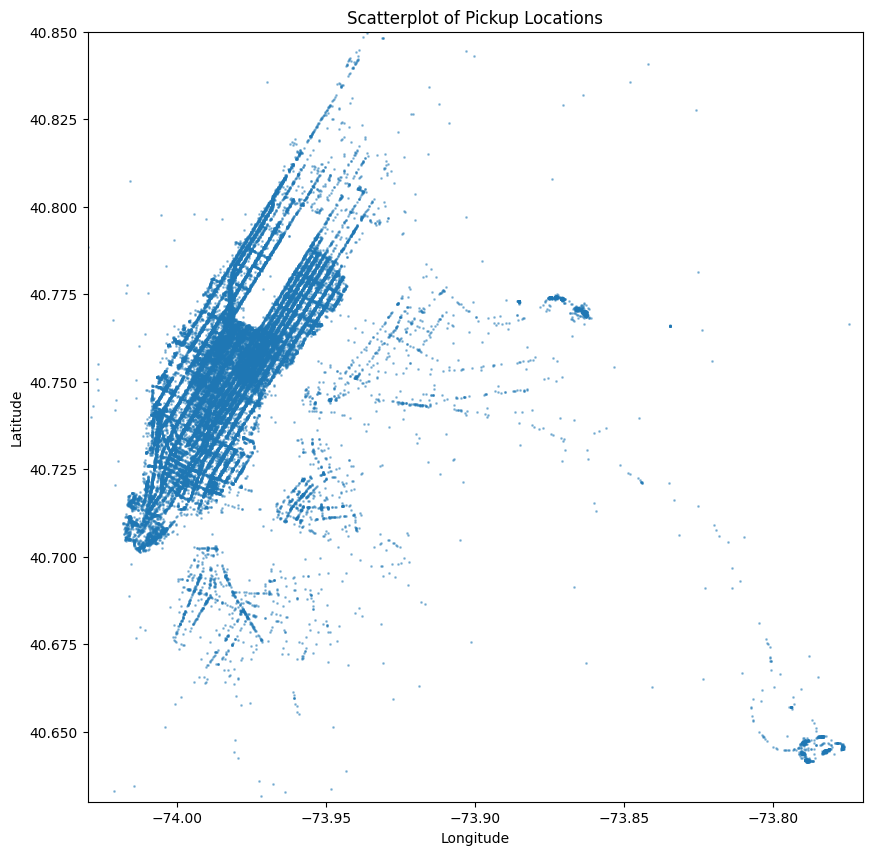

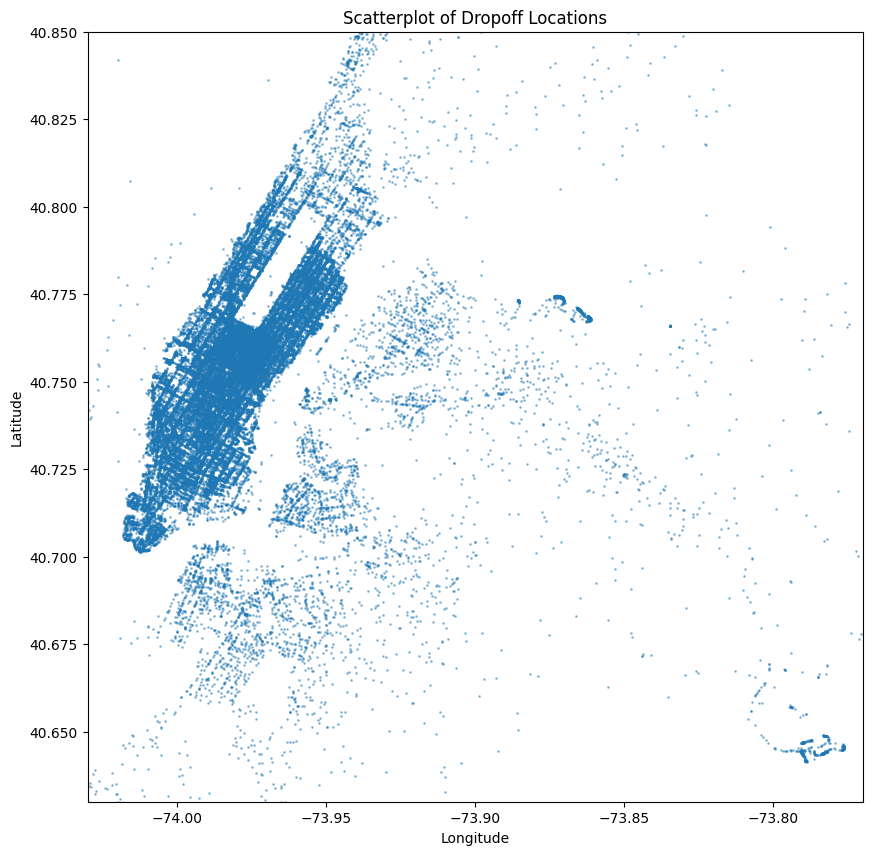

In [ ]:
# Scatter plot for pickup locations (zoomed in)
plt.figure(figsize=(10, 10))
plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], alpha=0.4, s=1)
plt.title('Scatterplot of Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
plt.show()

# Scatter plot for dropoff locations (zoomed in)
plt.figure(figsize=(10, 10))
plt.scatter(df_pd['dropoff_longitude'], df_pd['dropoff_latitude'], alpha=0.4, s=1)
plt.title('Scatterplot of Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
plt.show()

In [ ]:
# Count the number of trips for each passenger count
passenger_count_distribution = df.groupBy("passenger_count").count().orderBy("passenger_count")

# Show the distribution
passenger_count_distribution.show()

+---------------+-----+
|passenger_count|count|
+---------------+-----+
|              0|    2|
|              1|43276|
|              2| 7908|
|              3| 1964|
|              4| 1130|
|              5|   38|
|              6|    7|
+---------------+-----+



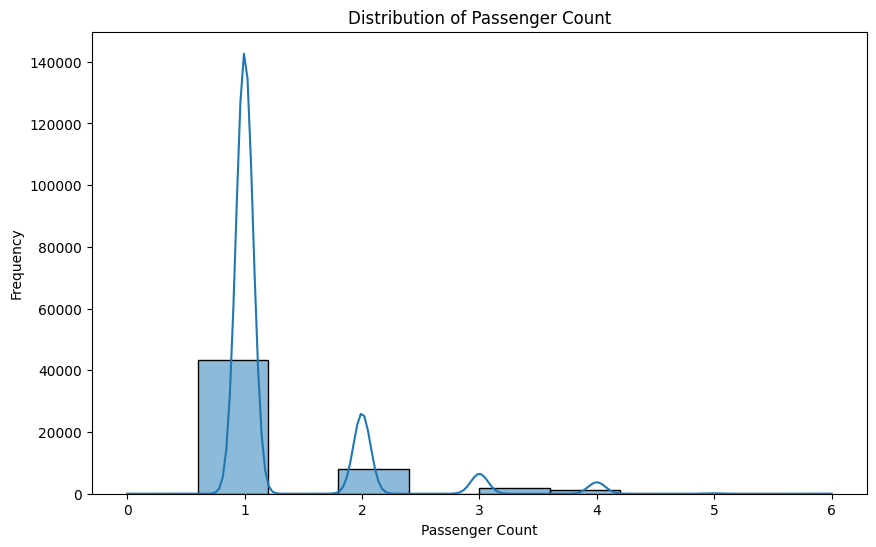

In [ ]:
# Histogram for passenger_count
plt.figure(figsize=(10, 6))
sns.histplot(df_pd['passenger_count'], bins=10, kde=True)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from pyspark.sql.functions import col

# Compute the counts of each unique value in store_and_fwd_flag
store_and_fwd_flag_distribution = df.groupBy("store_and_fwd_flag").count()

# Compute the total number of rows
total_count = df.count()

# Normalize the counts
store_and_fwd_flag_distribution = store_and_fwd_flag_distribution.withColumn("percentage", col("count") / total_count)

# Show the distribution
store_and_fwd_flag_distribution.show()


+------------------+-----+--------------------+
|store_and_fwd_flag|count|          percentage|
+------------------+-----+--------------------+
|                 Y| 1011|0.018610216290842155|
|                 N|53314|  0.9813897837091579|
+------------------+-----+--------------------+



In [ ]:
from pyspark.sql.functions import hour, dayofmonth, month, dayofweek, col, unix_timestamp, when

# Extract additional features from pickup_datetime
df = df.withColumn("pickup_hour", hour(col("pickup_datetime")))
df = df.withColumn("dropoff_hour", hour(col("dropoff_datetime")))
df = df.withColumn("pickup_day", dayofweek(col("pickup_datetime")))
df = df.withColumn("dropoff_day", dayofweek(col("dropoff_datetime")))

# Define time of day based on hour
df = df.withColumn("pickup_timeofday",
                   when(col("pickup_hour").between(5, 11), "Morning")
                   .when(col("pickup_hour").between(12, 16), "Afternoon")
                   .when(col("pickup_hour").between(17, 20), "Evening")
                   .otherwise("Late night"))

df = df.withColumn("dropoff_timeofday",
                   when(col("dropoff_hour").between(5, 11), "Morning")
                   .when(col("dropoff_hour").between(12, 16), "Afternoon")
                   .when(col("dropoff_hour").between(17, 20), "Evening")
                   .otherwise("Late night"))

# Show the dataframe with new features
df.select("pickup_datetime", "pickup_hour", "pickup_timeofday", "pickup_day",
          "dropoff_datetime", "dropoff_hour", "dropoff_timeofday", "dropoff_day").show(5)


+-------------------+-----------+----------------+----------+-------------------+------------+-----------------+-----------+
|    pickup_datetime|pickup_hour|pickup_timeofday|pickup_day|   dropoff_datetime|dropoff_hour|dropoff_timeofday|dropoff_day|
+-------------------+-----------+----------------+----------+-------------------+------------+-----------------+-----------+
|2013-12-23 00:30:45|          0|      Late night|         2|2013-12-23 00:35:28|           0|       Late night|          2|
|2013-12-23 00:34:14|          0|      Late night|         2|2013-12-23 00:43:41|           0|       Late night|          2|
|2013-12-23 01:49:09|          1|      Late night|         2|2013-12-23 01:53:06|           1|       Late night|          2|
|2013-12-23 00:41:05|          0|      Late night|         2|2013-12-23 00:51:12|           0|       Late night|          2|
|2013-12-23 00:47:16|          0|      Late night|         2|2013-12-23 01:05:59|           1|       Late night|          2|


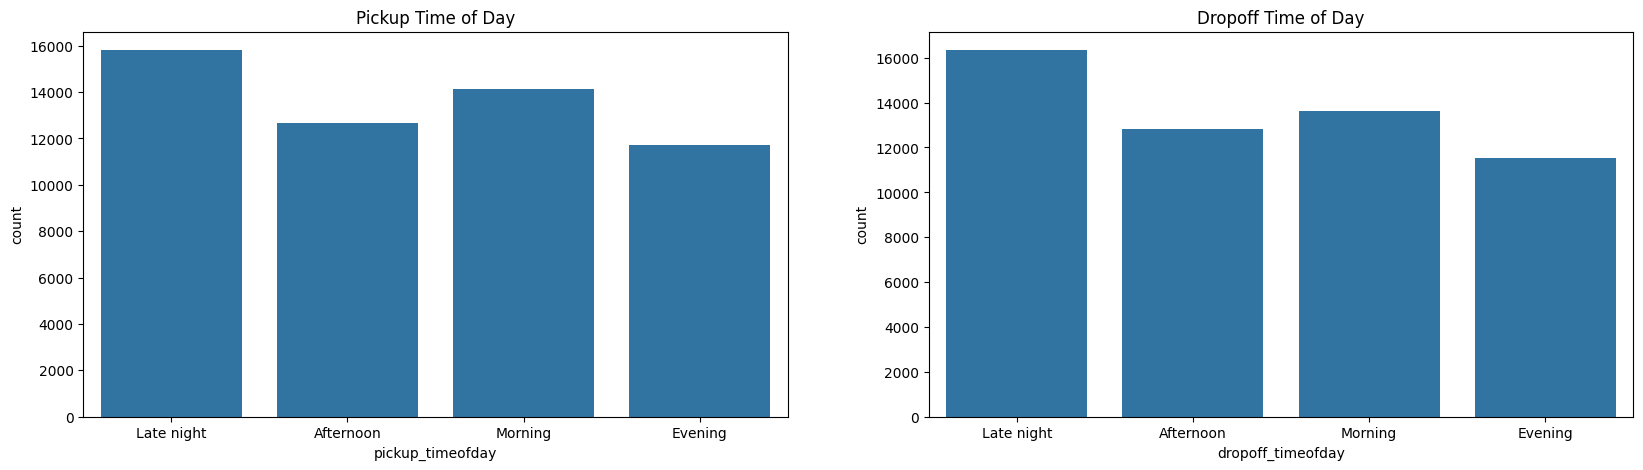

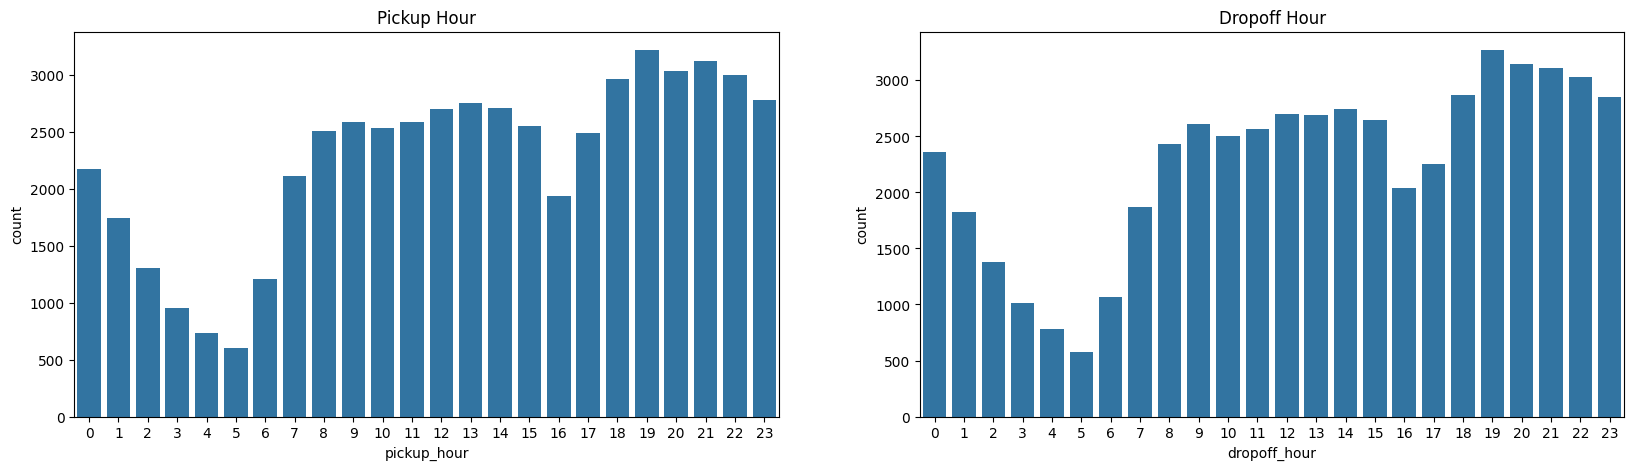

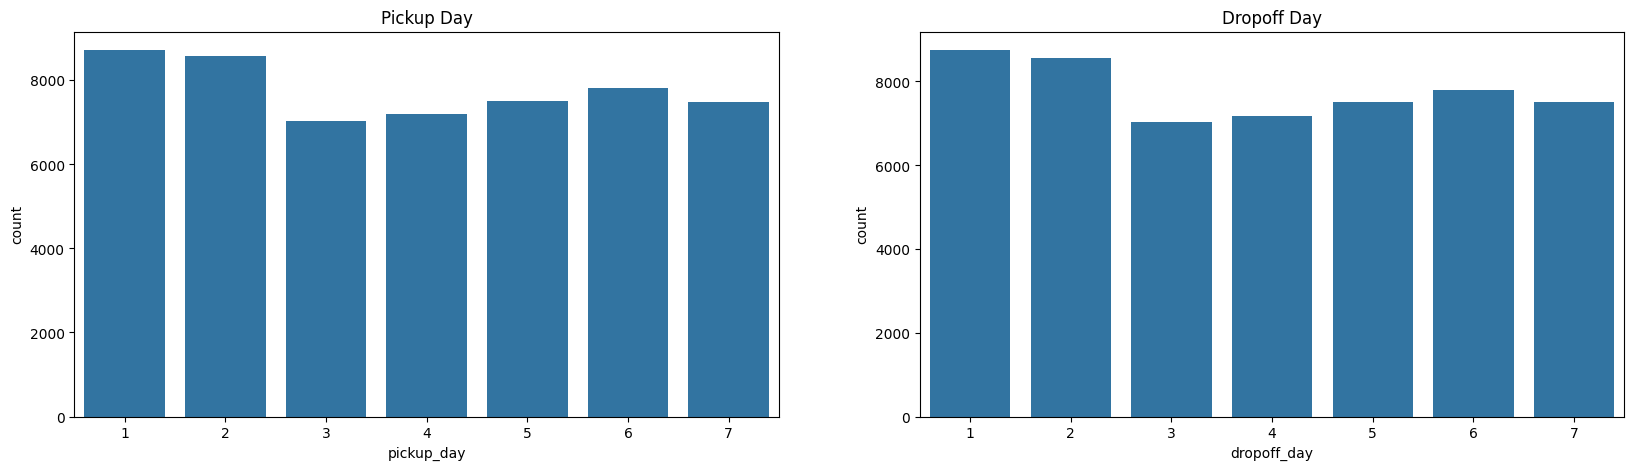

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for plotting
df_pd = df.toPandas()

# Set up the figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot pickup and dropoff times of day
ax1.set_title('Pickup Time of Day')
sns.countplot(x="pickup_timeofday", data=df_pd, ax=ax1)

ax2.set_title('Dropoff Time of Day')
sns.countplot(x="dropoff_timeofday", data=df_pd, ax=ax2)

plt.show()

# Set up the figure
fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot pickup and dropoff hours
ax3.set_title('Pickup Hour')
sns.countplot(x="pickup_hour", data=df_pd, ax=ax3)

ax4.set_title('Dropoff Hour')
sns.countplot(x="dropoff_hour", data=df_pd, ax=ax4)

plt.show()

# Set up the figure
fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot pickup and dropoff days
ax5.set_title('Pickup Day')
sns.countplot(x="pickup_day", data=df_pd, ax=ax5)

ax6.set_title('Dropoff Day')
sns.countplot(x="dropoff_day", data=df_pd, ax=ax6)

plt.show()


#Bivariate Analysis

In [ ]:
# Calculate trip duration in minutes
df = df.withColumn("trip_duration",
                   (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)

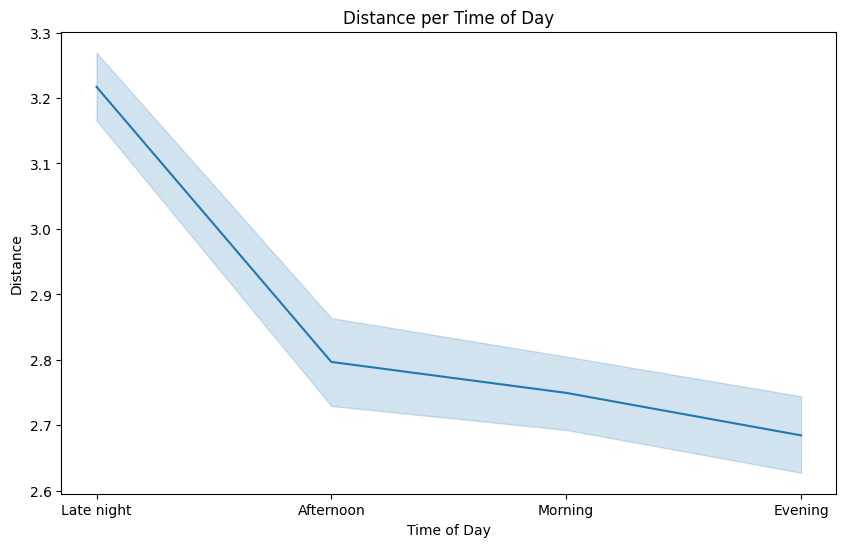

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_timeofday', y='trip_distance', data=df_pd)
plt.title('Distance per Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Distance')
plt.show()


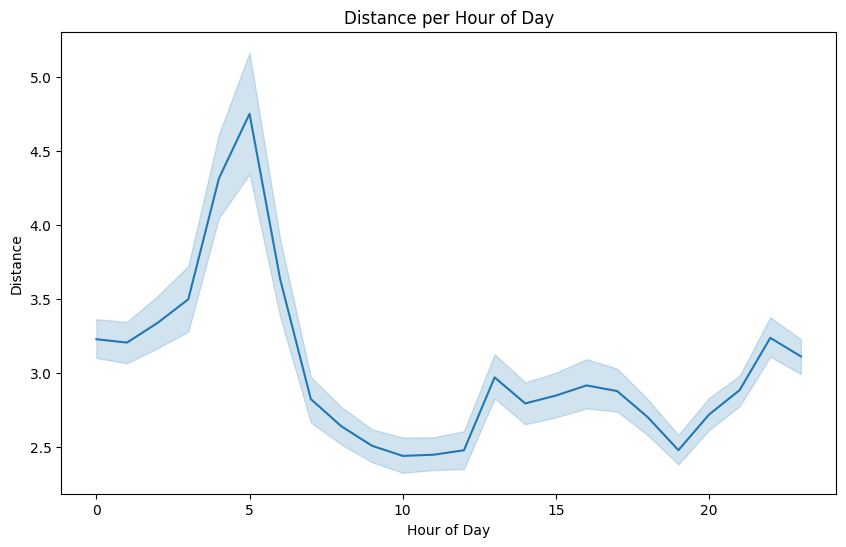

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_hour', y='trip_distance', data=df_pd)
plt.title('Distance per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Distance')
plt.show()


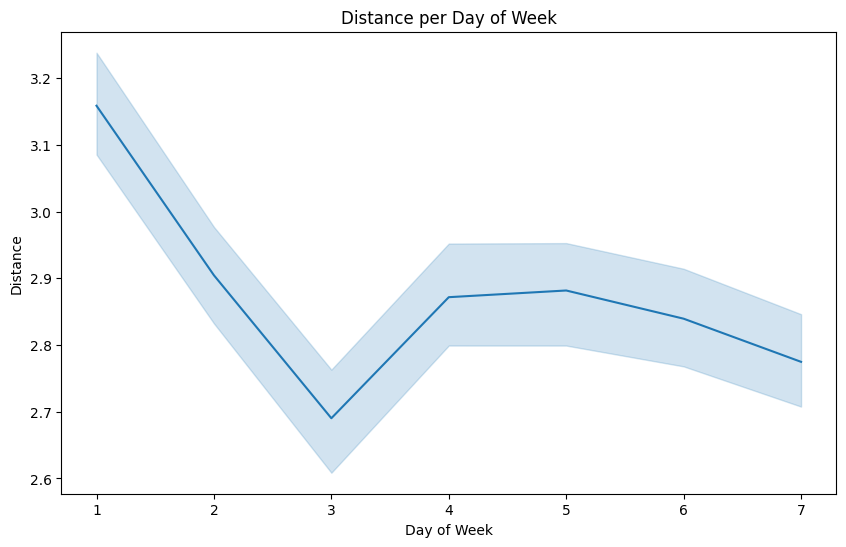

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_day', y='trip_distance', data=df_pd)
plt.title('Distance per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Distance')
plt.show()


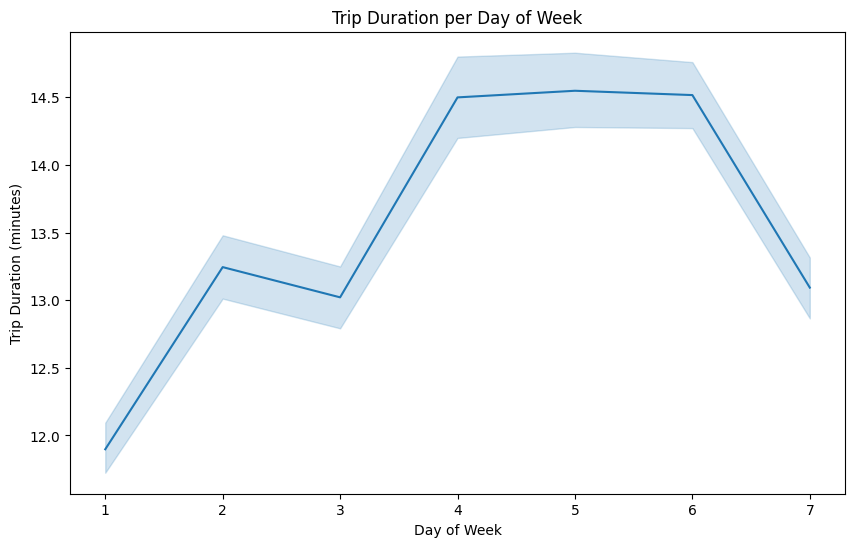

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_day', y='trip_duration', data=df_pd)
plt.title('Trip Duration per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Trip Duration (minutes)')
plt.show()


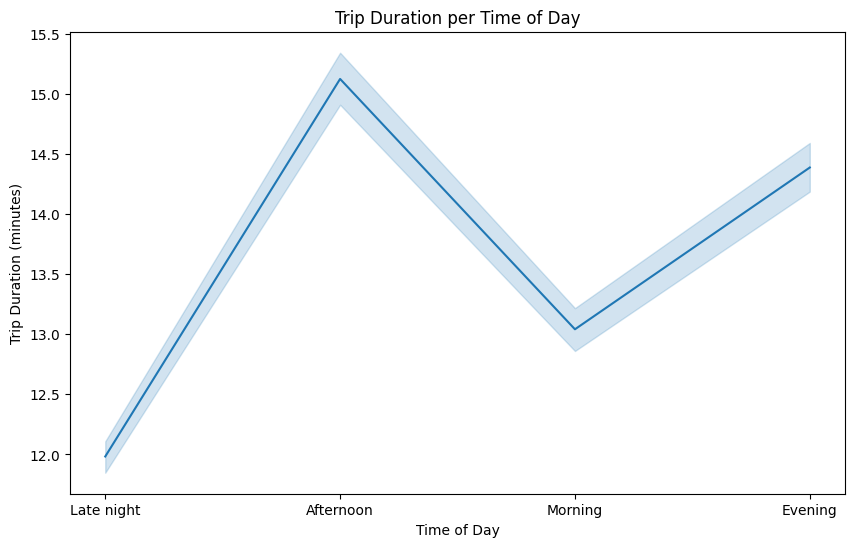

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_timeofday', y='trip_duration', data=df_pd)
plt.title('Trip Duration per Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Trip Duration (minutes)')
plt.show()


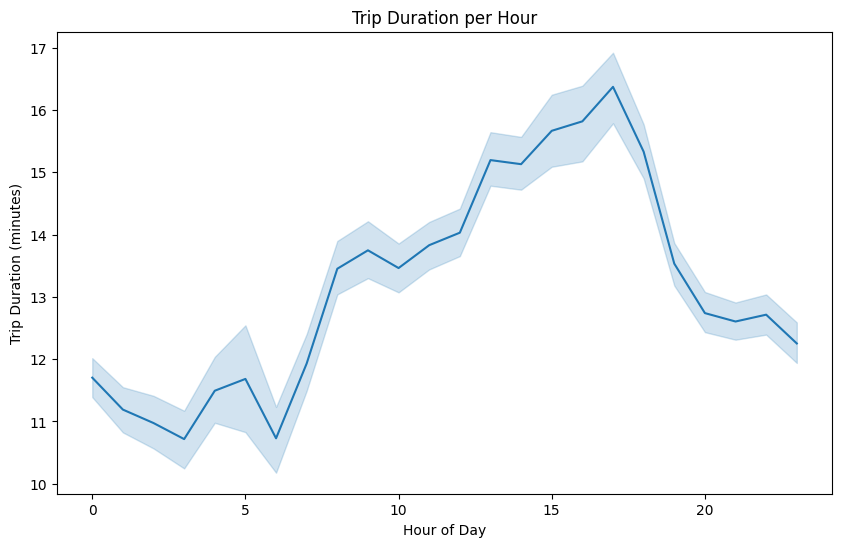

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', data=df_pd)
plt.title('Trip Duration per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Duration (minutes)')
plt.show()


<Figure size 1000x600 with 0 Axes>

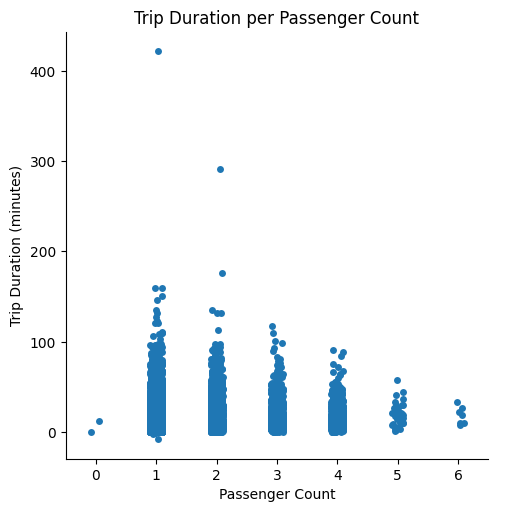

In [ ]:
plt.figure(figsize=(10, 6))
sns.catplot(y='trip_duration', x='passenger_count', data=df_pd, kind="strip")
plt.title('Trip Duration per Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Trip Duration (minutes)')
plt.show()


# During CHIRSTMAS Holiday

In [ ]:
from pyspark.sql.functions import col, count, when

# Inspect the dataset
df_2.printSchema()
df_2.describe().show()

# Check for missing values
missing_values = df_2.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_1.columns
])
missing_values.show()

# Drop rows with any null values (optional, based on your needs)
df2_cleaned = df_2.dropna()

# Show the cleaned data
df2_cleaned.show(5)

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- date: date (nullable = true)

+-------+--------------------+--------------------+---------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+
|summary|           medallion|        hack_license|vendor_id|          rate_

In [ ]:
df2_cleaned.count()

29428

In [ ]:
df2 = df2_cleaned

# Feature Engineering

In [ ]:
from pyspark.sql.functions import hour, dayofmonth, month, dayofweek, col, unix_timestamp

# Extract additional features from pickup_datetime
df2 = df2.withColumn("pickup_hour", hour(col("pickup_datetime")))
df2 = df2.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))
df2 = df2.withColumn("pickup_month", month(col("pickup_datetime")))
df2 = df2.withColumn("pickup_day_of_week", dayofweek(col("pickup_datetime")))

# Calculate trip duration in minutes
df2 = df2.withColumn("trip_duration",
                   (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)

# Show the dataframe with new features
df2.show(5)


+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+----------+-----------+----------+------------+------------------+------------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|      date|pickup_hour|pickup_day|pickup_month|pickup_day_of_week|     trip_duration|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+----------+-----------+----------+------------+------------------+------------------+
|BF9FD47CB82BFBAF2...|B81CE4

In [ ]:
# Summary statistics for numerical features
df2.describe().show()

# Summary statistics for categorical features
categorical_features = ['vendor_id', 'rate_code', 'store_and_fwd_flag']
for feature in categorical_features:
    df2.groupBy(feature).count().show()


+-------+--------------------+--------------------+---------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------+------------------+--------------------+
|summary|           medallion|        hack_license|vendor_id|          rate_code|store_and_fwd_flag|   passenger_count| trip_time_in_secs|     trip_distance| pickup_longitude|   pickup_latitude| dropoff_longitude| dropoff_latitude|       pickup_hour|        pickup_day|pickup_month|pickup_day_of_week|       trip_duration|
+-------+--------------------+--------------------+---------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------+------------------+--------------------+
|  count|               29428| 

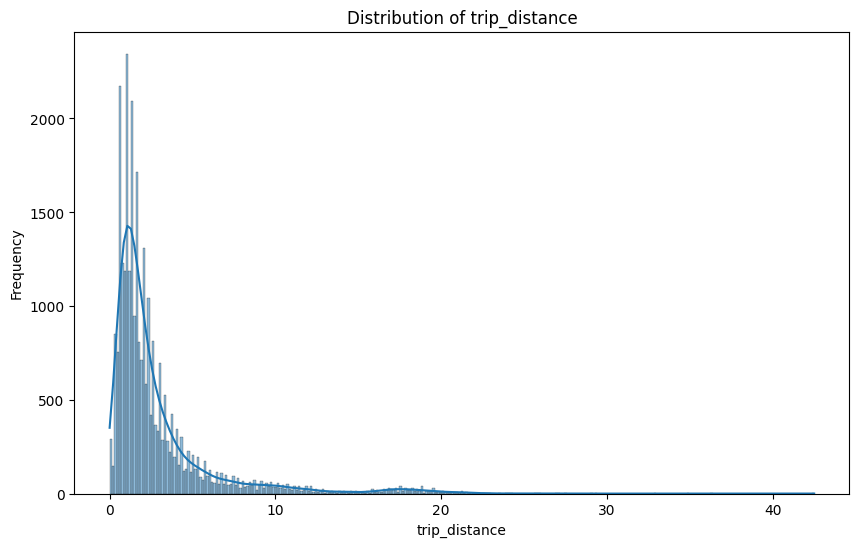

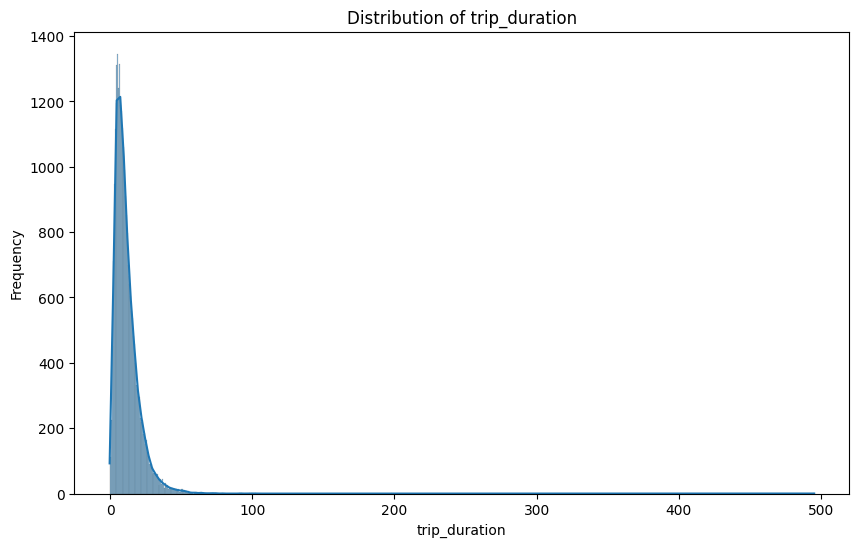

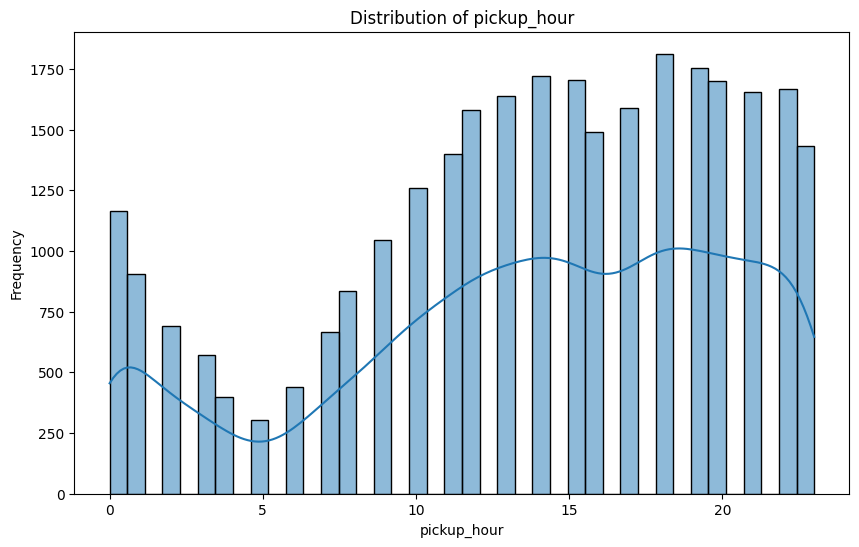

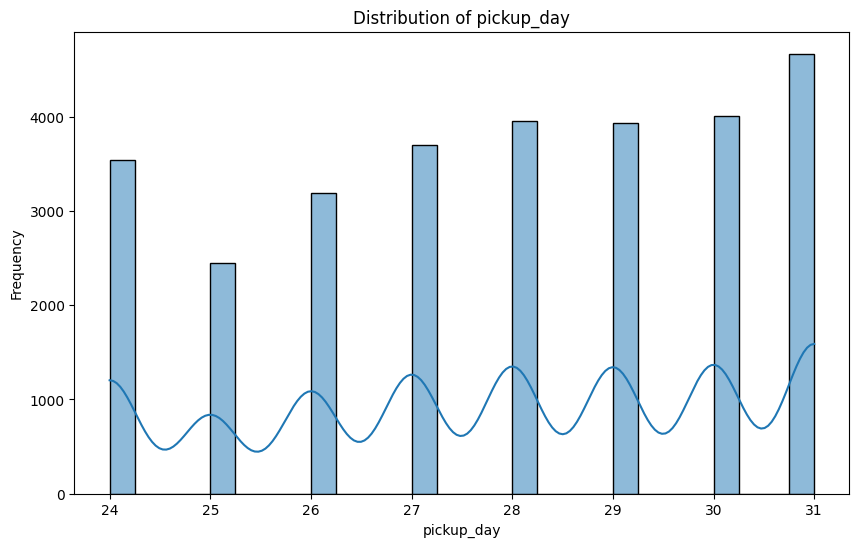

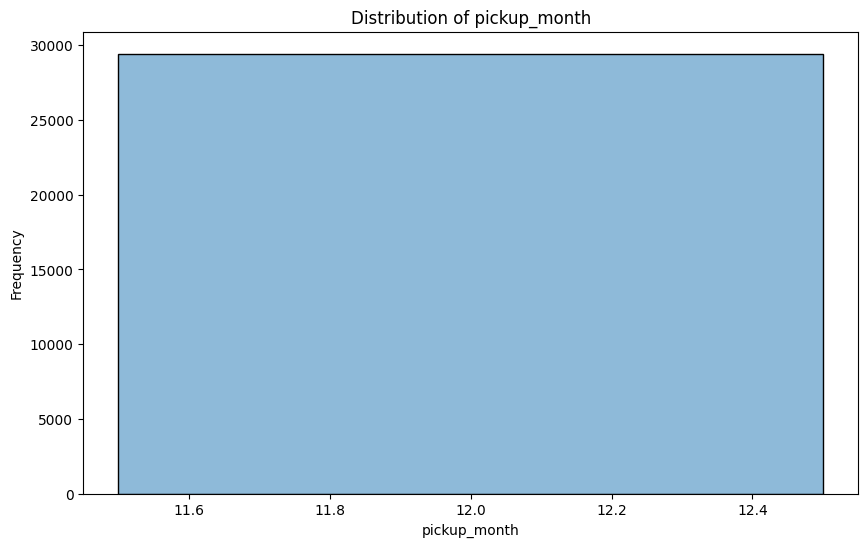

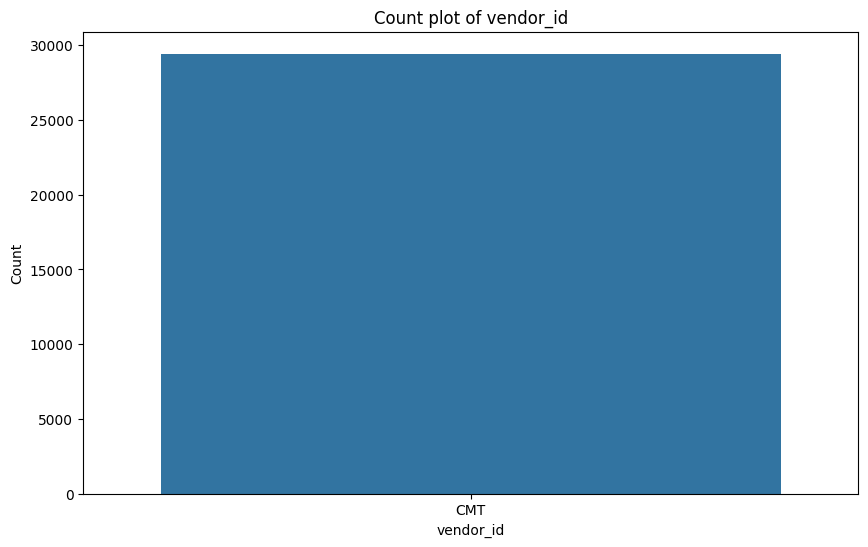

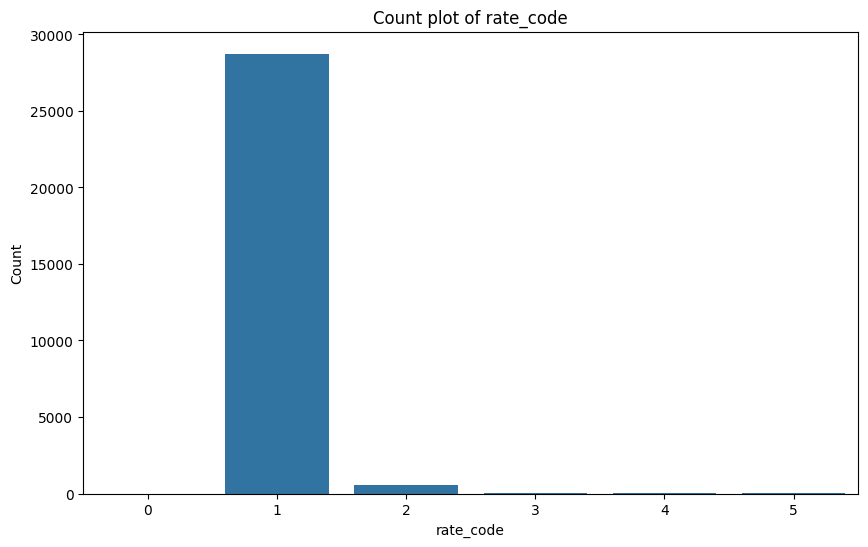

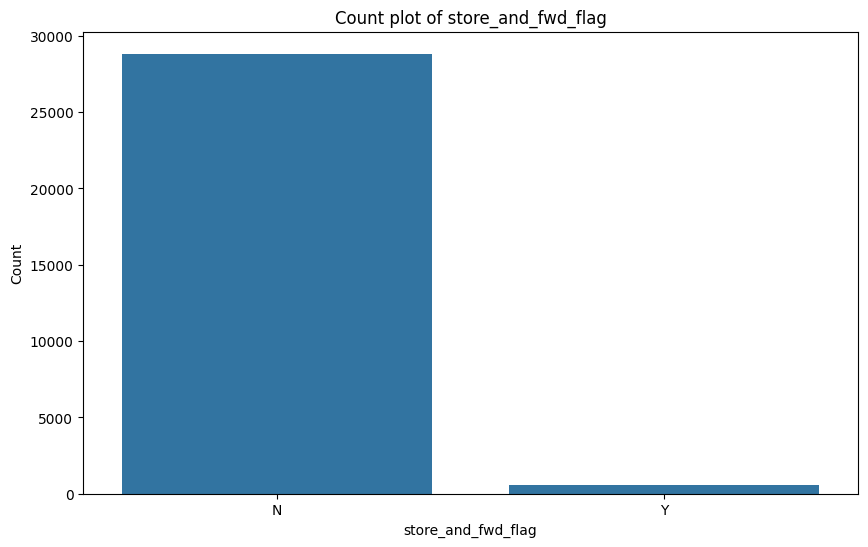

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for plotting
df2_pd = df2.toPandas()

# Distribution plots for numerical features
numerical_features = ['trip_distance', 'trip_duration', 'pickup_hour', 'pickup_day', 'pickup_month']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df2_pd[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Count plots for categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df2_pd[feature])
    plt.title(f'Count plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


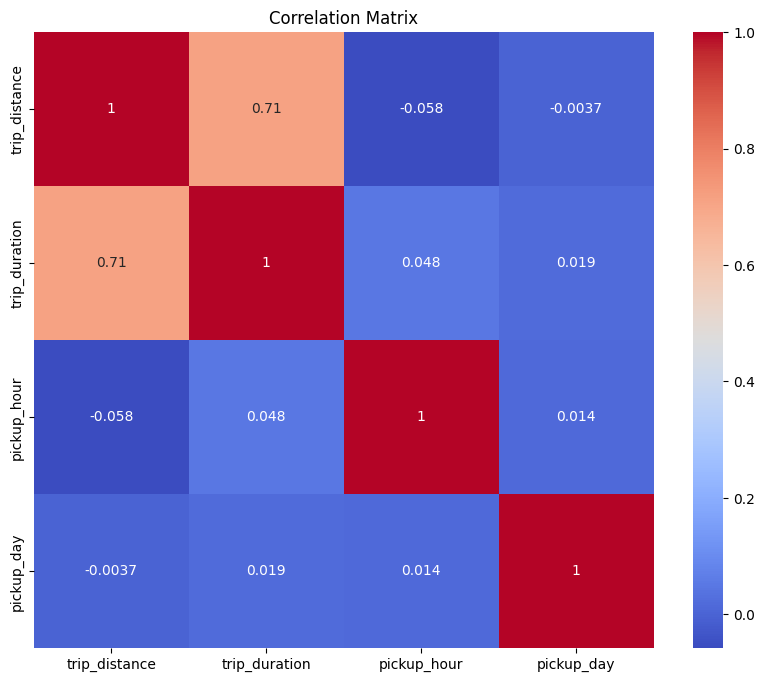

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute the correlation matrix
correlation_matrix = df2_pd[['trip_distance', 'trip_duration', 'pickup_hour', 'pickup_day']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


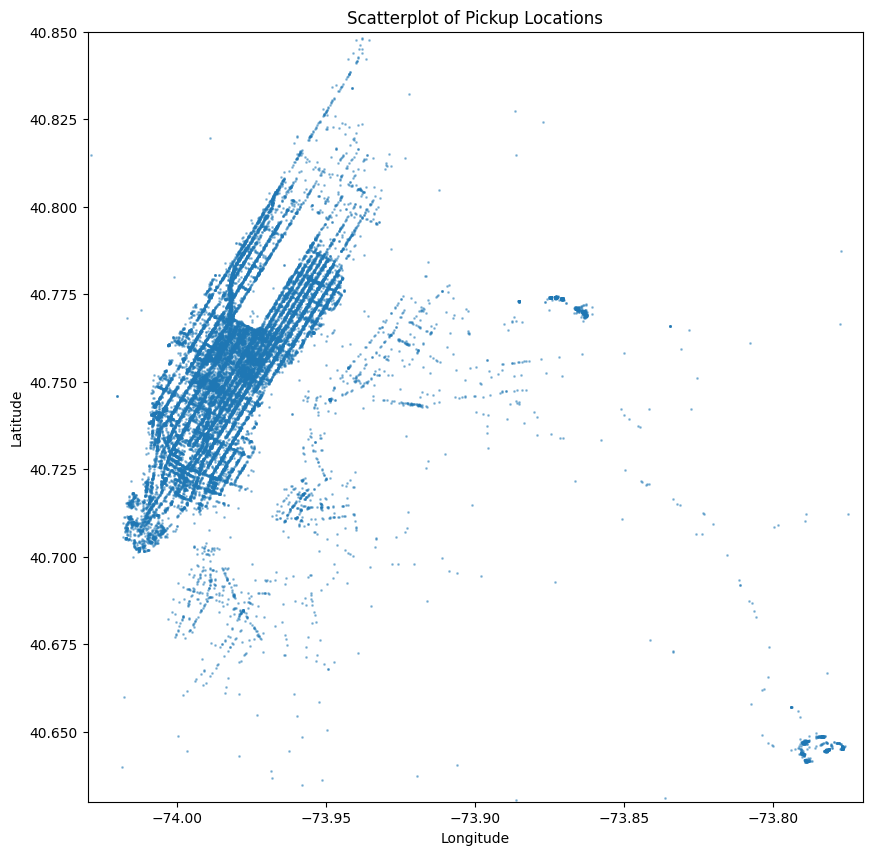

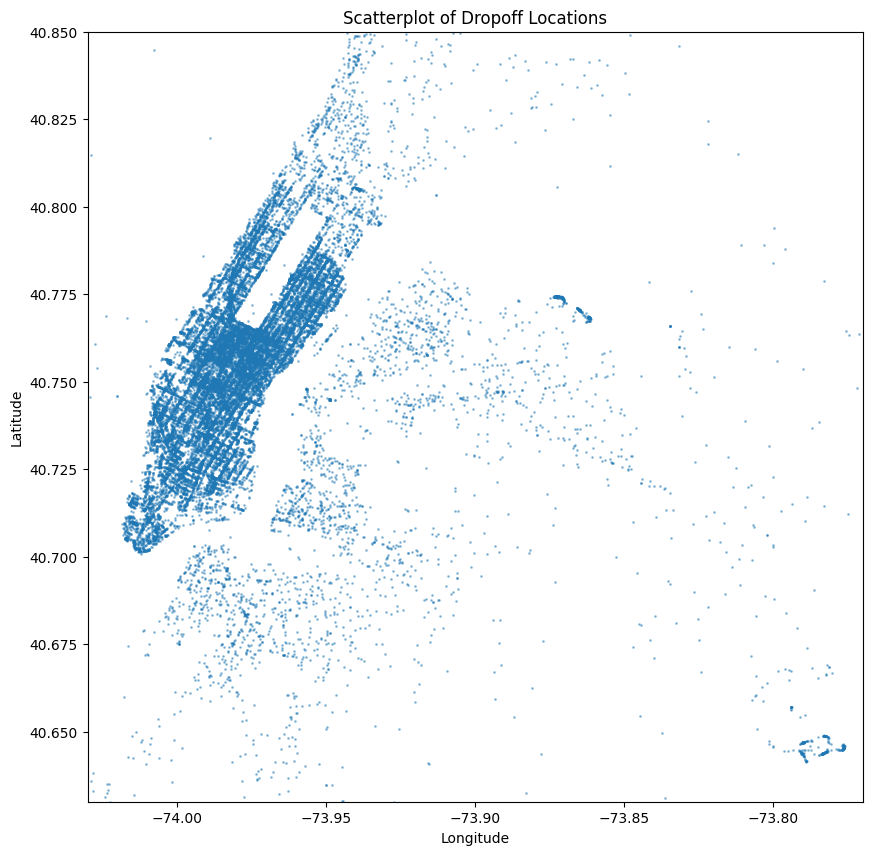

In [ ]:
# Scatter plot for pickup locations (zoomed in)
plt.figure(figsize=(10, 10))
plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], alpha=0.4, s=1)
plt.title('Scatterplot of Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
plt.show()

# Scatter plot for dropoff locations (zoomed in)
plt.figure(figsize=(10, 10))
plt.scatter(df2_pd['dropoff_longitude'], df2_pd['dropoff_latitude'], alpha=0.4, s=1)
plt.title('Scatterplot of Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
plt.show()

In [ ]:
# Count the number of trips for each passenger count
passenger_count_distribution = df2.groupBy("passenger_count").count().orderBy("passenger_count")

# Show the distribution
passenger_count_distribution.show()

+---------------+-----+
|passenger_count|count|
+---------------+-----+
|              1|21163|
|              2| 5171|
|              3| 1794|
|              4| 1266|
|              5|   30|
|              6|    4|
+---------------+-----+



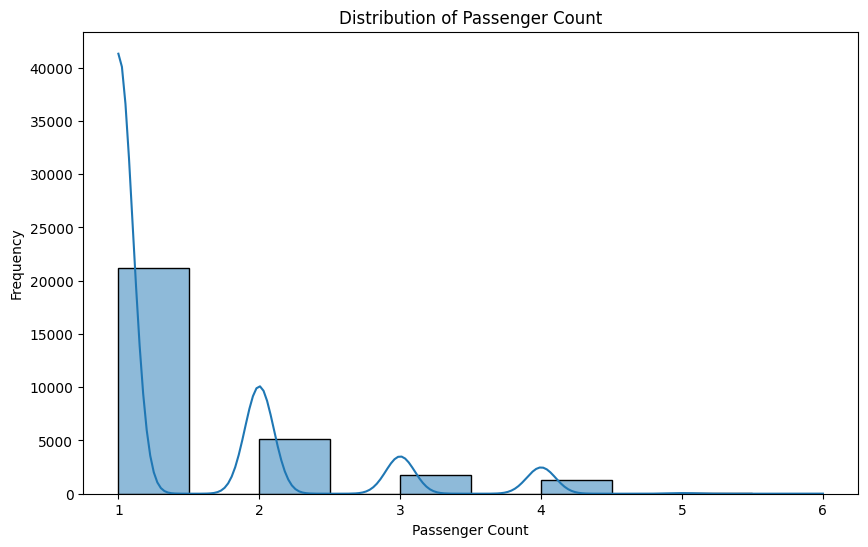

In [ ]:
# Histogram for passenger_count
plt.figure(figsize=(10, 6))
sns.histplot(df2_pd['passenger_count'], bins=10, kde=True)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from pyspark.sql.functions import col

# Compute the counts of each unique value in store_and_fwd_flag
store_and_fwd_flag_distribution = df2.groupBy("store_and_fwd_flag").count()

# Compute the total number of rows
total_count = df2.count()

# Normalize the counts
store_and_fwd_flag_distribution = store_and_fwd_flag_distribution.withColumn("percentage", col("count") / total_count)

# Show the distribution
store_and_fwd_flag_distribution.show()


+------------------+-----+--------------------+
|store_and_fwd_flag|count|          percentage|
+------------------+-----+--------------------+
|                 N|28838|  0.9799510670110099|
|                 Y|  590|0.020048932988990076|
+------------------+-----+--------------------+



In [ ]:
from pyspark.sql.functions import hour, dayofmonth, month, dayofweek, col, unix_timestamp, when

# Extract additional features from pickup_datetime
df2 = df2.withColumn("pickup_hour", hour(col("pickup_datetime")))
df2 = df2.withColumn("dropoff_hour", hour(col("dropoff_datetime")))
df2 = df2.withColumn("pickup_day", dayofweek(col("pickup_datetime")))
df2 = df2.withColumn("dropoff_day", dayofweek(col("dropoff_datetime")))

# Define time of day based on hour
df2 = df2.withColumn("pickup_timeofday",
                   when(col("pickup_hour").between(5, 11), "Morning")
                   .when(col("pickup_hour").between(12, 16), "Afternoon")
                   .when(col("pickup_hour").between(17, 20), "Evening")
                   .otherwise("Late night"))

df2 = df2.withColumn("dropoff_timeofday",
                   when(col("dropoff_hour").between(5, 11), "Morning")
                   .when(col("dropoff_hour").between(12, 16), "Afternoon")
                   .when(col("dropoff_hour").between(17, 20), "Evening")
                   .otherwise("Late night"))

# Show the dataframe with new features
df2.select("pickup_datetime", "pickup_hour", "pickup_timeofday", "pickup_day",
          "dropoff_datetime", "dropoff_hour", "dropoff_timeofday", "dropoff_day").show(5)


+-------------------+-----------+----------------+----------+-------------------+------------+-----------------+-----------+
|    pickup_datetime|pickup_hour|pickup_timeofday|pickup_day|   dropoff_datetime|dropoff_hour|dropoff_timeofday|dropoff_day|
+-------------------+-----------+----------------+----------+-------------------+------------+-----------------+-----------+
|2013-12-26 13:10:57|         13|       Afternoon|         5|2013-12-26 13:39:03|          13|        Afternoon|          5|
|2013-12-26 18:21:43|         18|         Evening|         5|2013-12-26 18:35:28|          18|          Evening|          5|
|2013-12-26 19:45:17|         19|         Evening|         5|2013-12-26 19:59:57|          19|          Evening|          5|
|2013-12-26 15:47:40|         15|       Afternoon|         5|2013-12-26 15:54:07|          15|        Afternoon|          5|
|2013-12-25 22:10:35|         22|      Late night|         4|2013-12-25 22:23:15|          22|       Late night|          4|


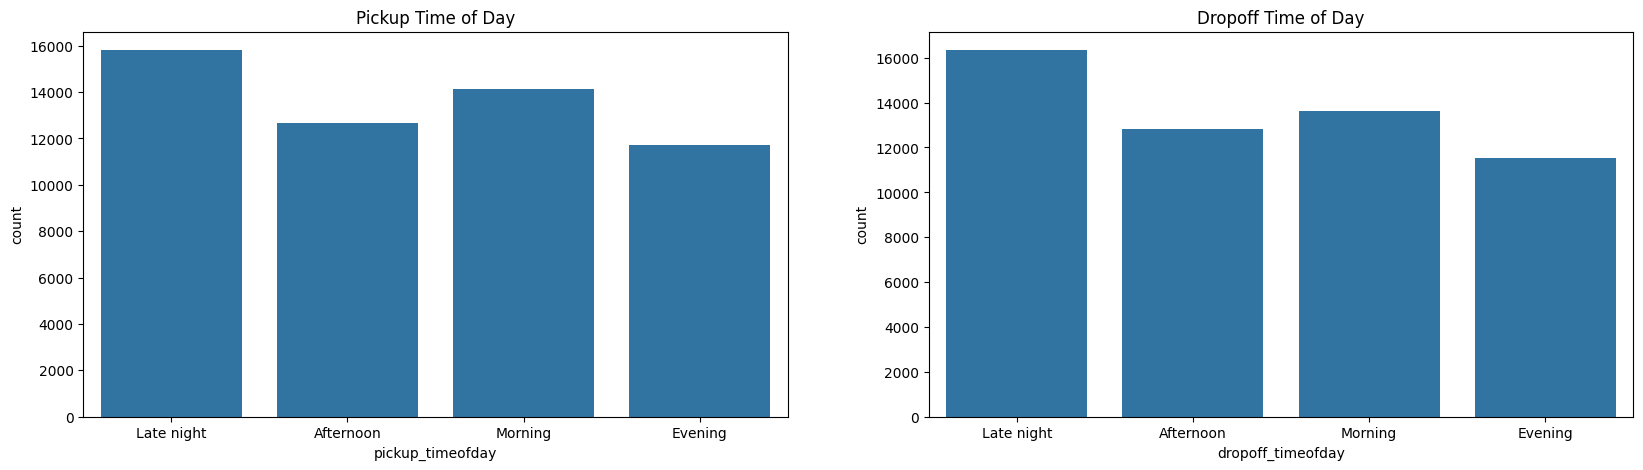

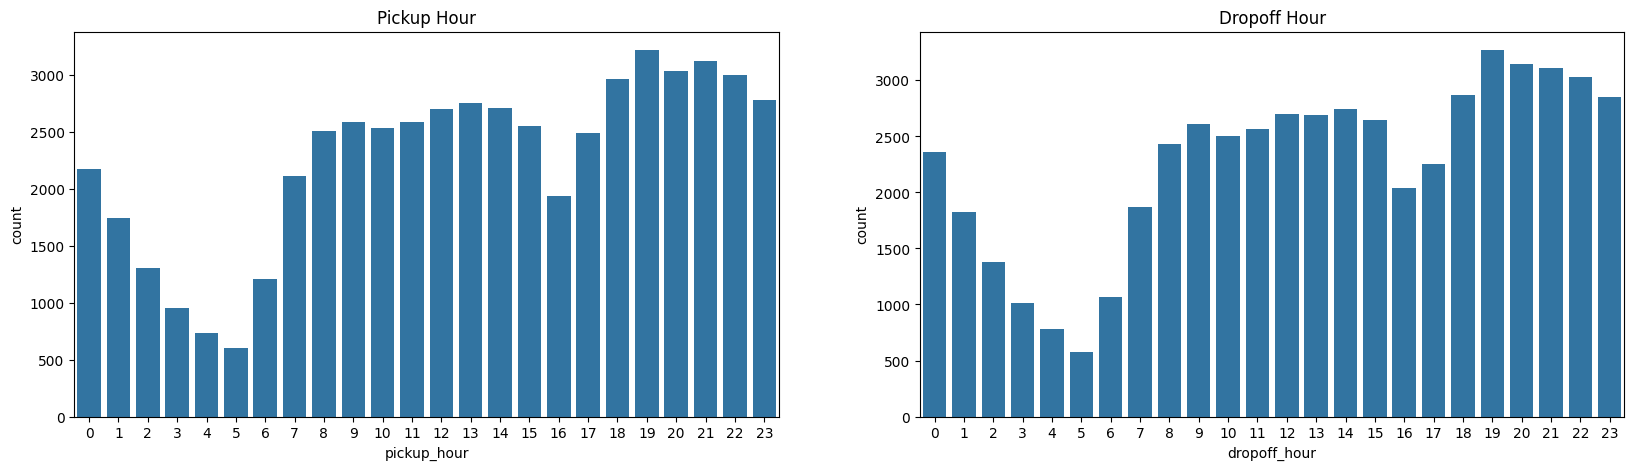

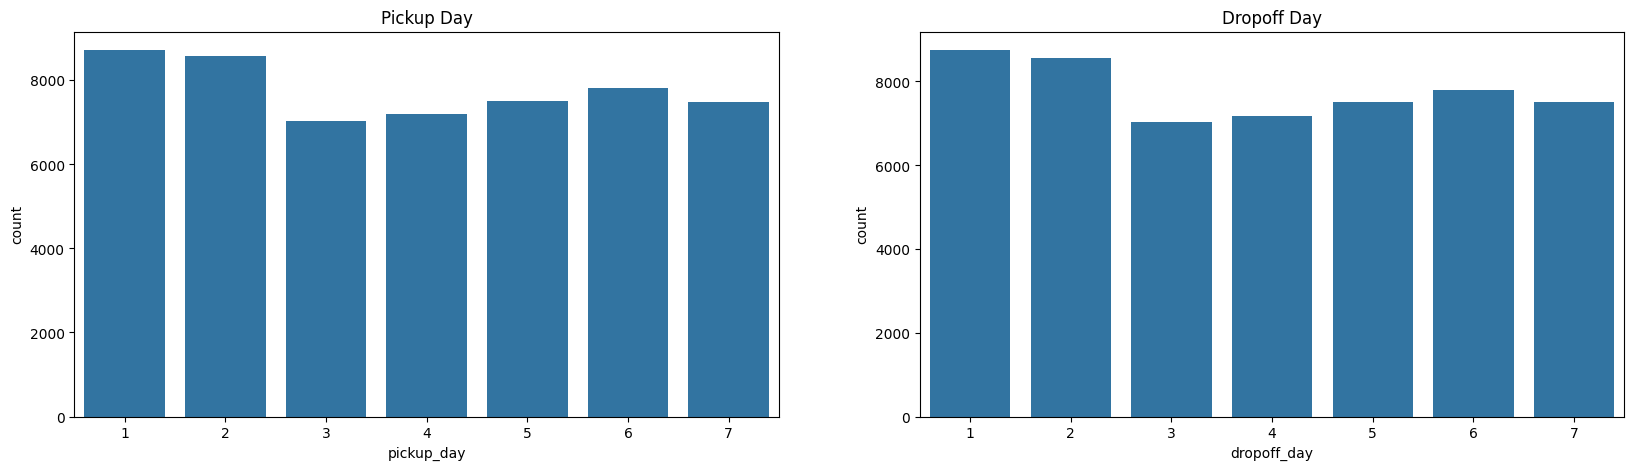

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for plotting
df2_pd = df2.toPandas()

# Set up the figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot pickup and dropoff times of day
ax1.set_title('Pickup Time of Day')
sns.countplot(x="pickup_timeofday", data=df_pd, ax=ax1)

ax2.set_title('Dropoff Time of Day')
sns.countplot(x="dropoff_timeofday", data=df_pd, ax=ax2)

plt.show()

# Set up the figure
fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot pickup and dropoff hours
ax3.set_title('Pickup Hour')
sns.countplot(x="pickup_hour", data=df_pd, ax=ax3)

ax4.set_title('Dropoff Hour')
sns.countplot(x="dropoff_hour", data=df_pd, ax=ax4)

plt.show()

# Set up the figure
fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot pickup and dropoff days
ax5.set_title('Pickup Day')
sns.countplot(x="pickup_day", data=df_pd, ax=ax5)

ax6.set_title('Dropoff Day')
sns.countplot(x="dropoff_day", data=df_pd, ax=ax6)

plt.show()


# Bivariate Analysis

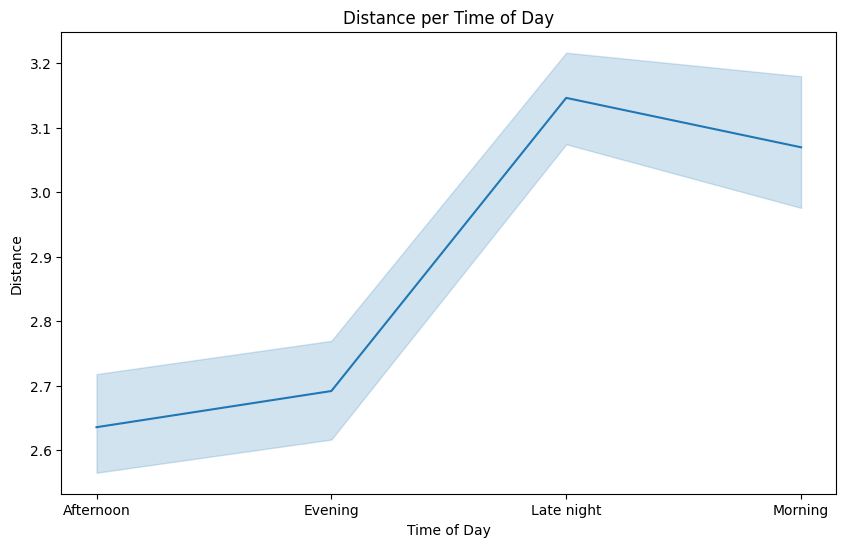

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_timeofday', y='trip_distance', data=df2_pd)
plt.title('Distance per Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Distance')
plt.show()


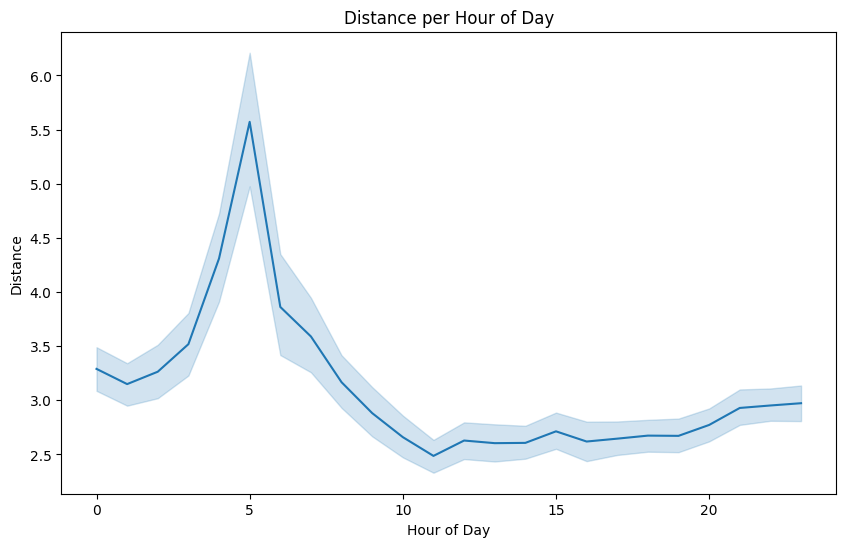

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_hour', y='trip_distance', data=df2_pd)
plt.title('Distance per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Distance')
plt.show()


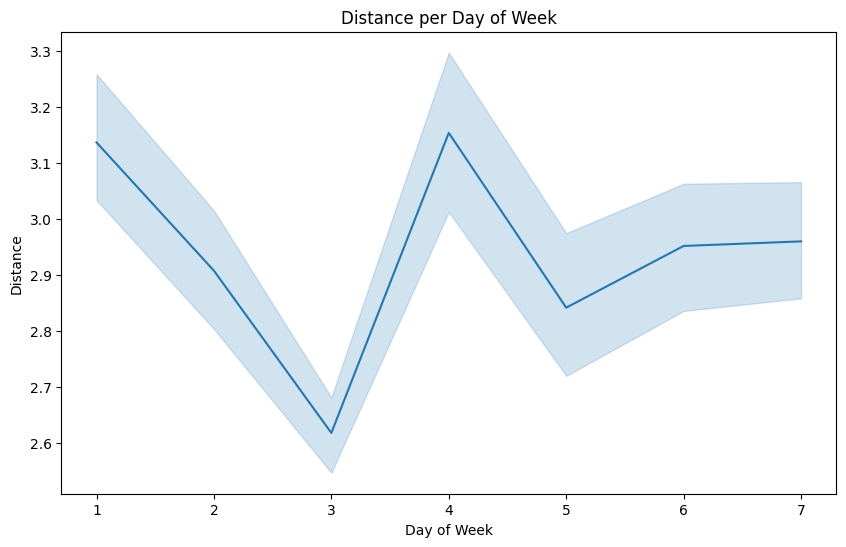

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_day', y='trip_distance', data=df2_pd)
plt.title('Distance per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Distance')
plt.show()


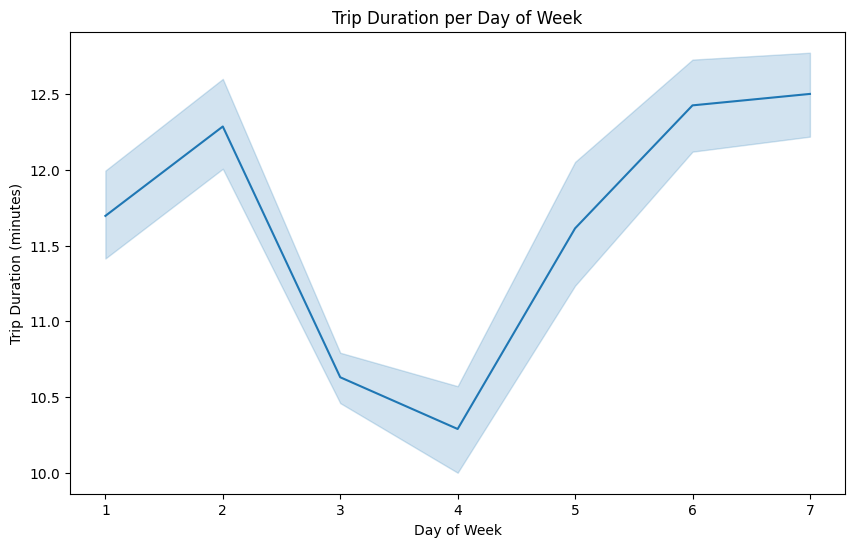

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_day', y='trip_duration', data=df2_pd)
plt.title('Trip Duration per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Trip Duration (minutes)')
plt.show()


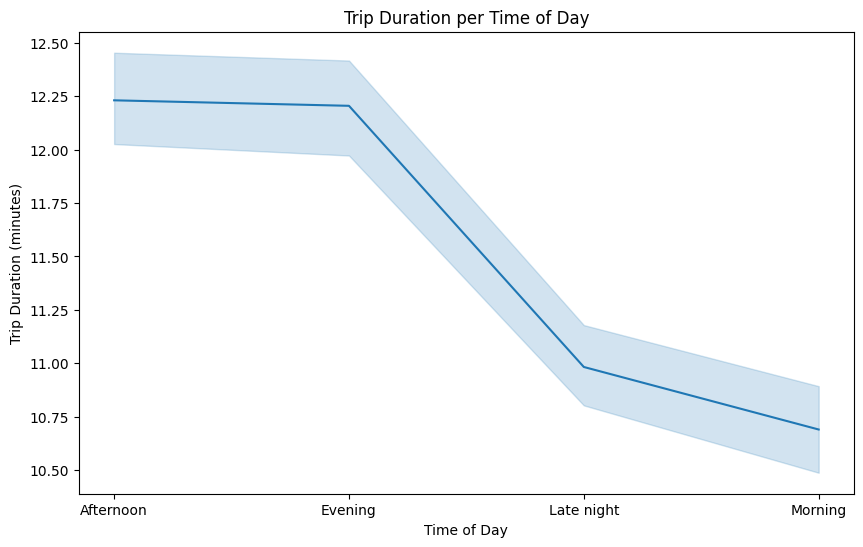

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_timeofday', y='trip_duration', data=df2_pd)
plt.title('Trip Duration per Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Trip Duration (minutes)')
plt.show()


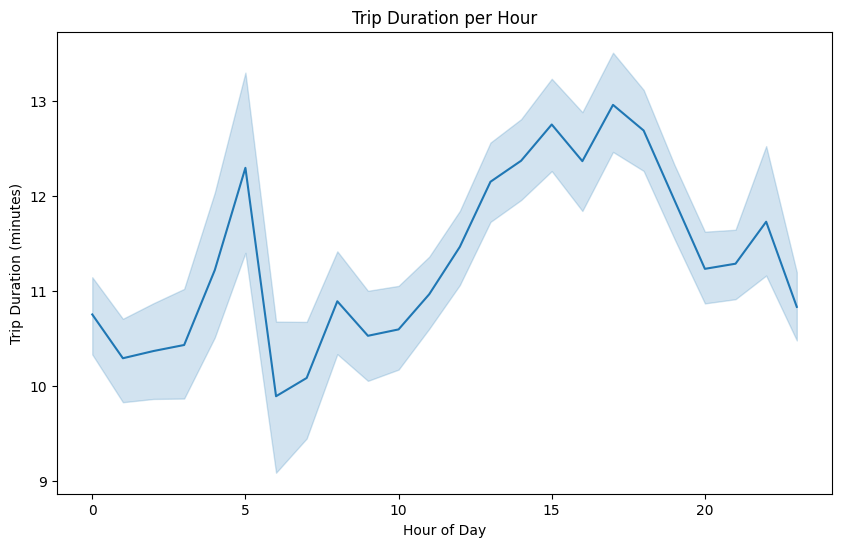

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', data=df2_pd)
plt.title('Trip Duration per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Duration (minutes)')
plt.show()


<Figure size 1000x600 with 0 Axes>

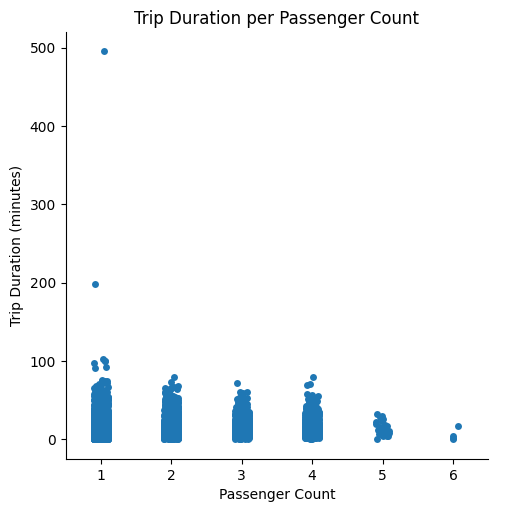

In [ ]:
plt.figure(figsize=(10, 6))
sns.catplot(y='trip_duration', x='passenger_count', data=df2_pd, kind="strip")
plt.title('Trip Duration per Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Trip Duration (minutes)')
plt.show()


## Comparision

Columns in df (before Christmas): Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'date', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_day_of_week', 'trip_duration', 'dropoff_hour', 'dropoff_day',
       'pickup_timeofday', 'dropoff_timeofday'],
      dtype='object')
Columns in df2 (during Christmas): Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'date', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_day_of_week', 'trip_duration', 'dropoff_hour', 'dropoff_day',
       'pickup_timeofday

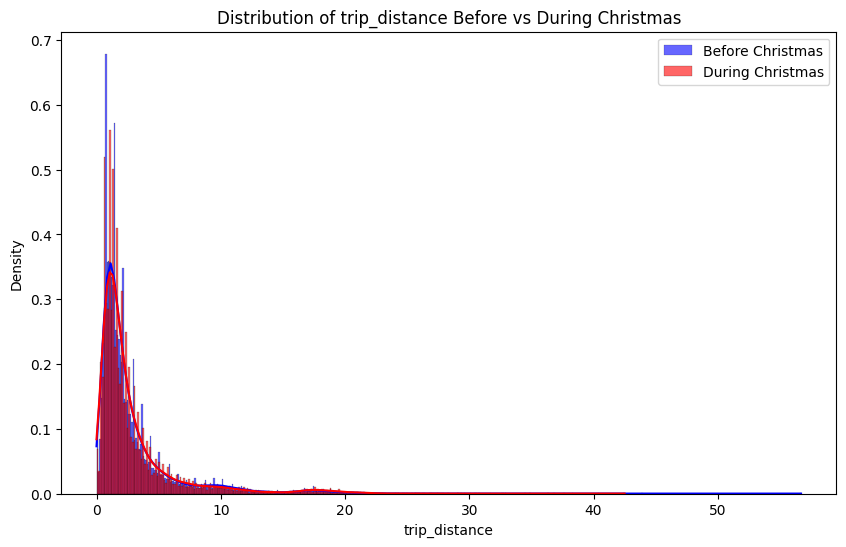

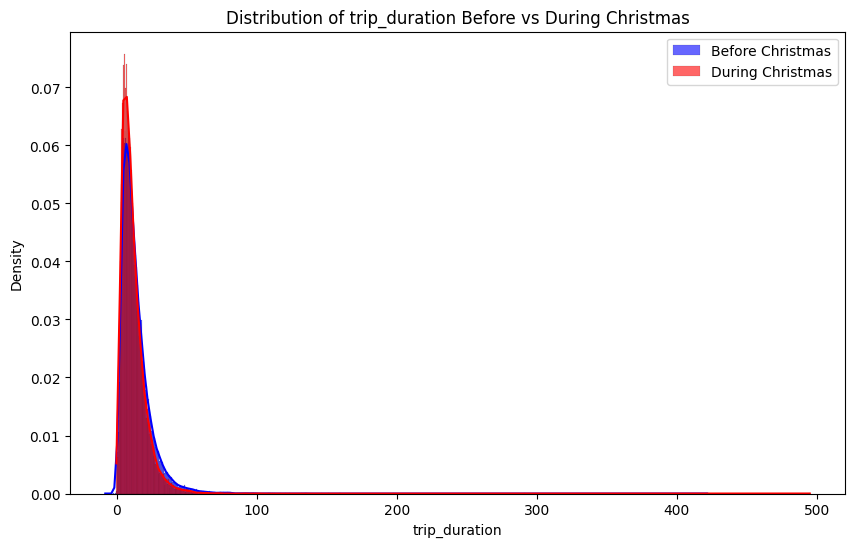

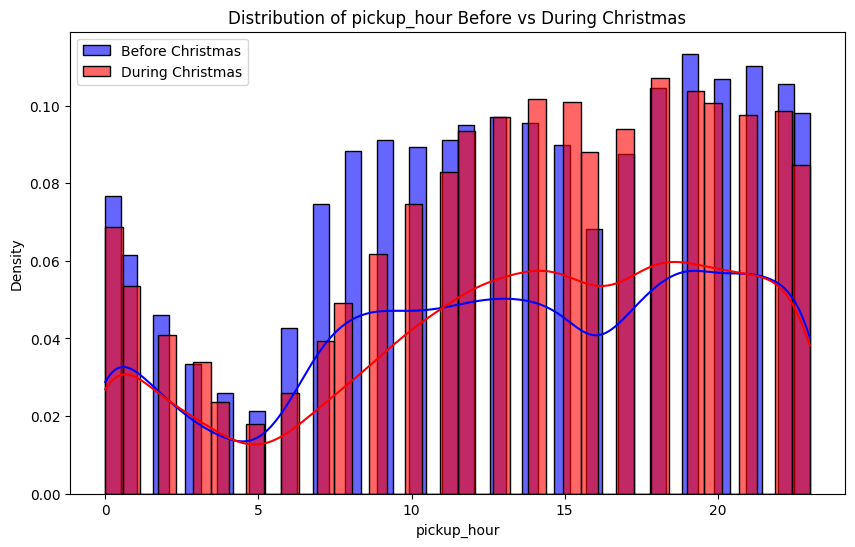

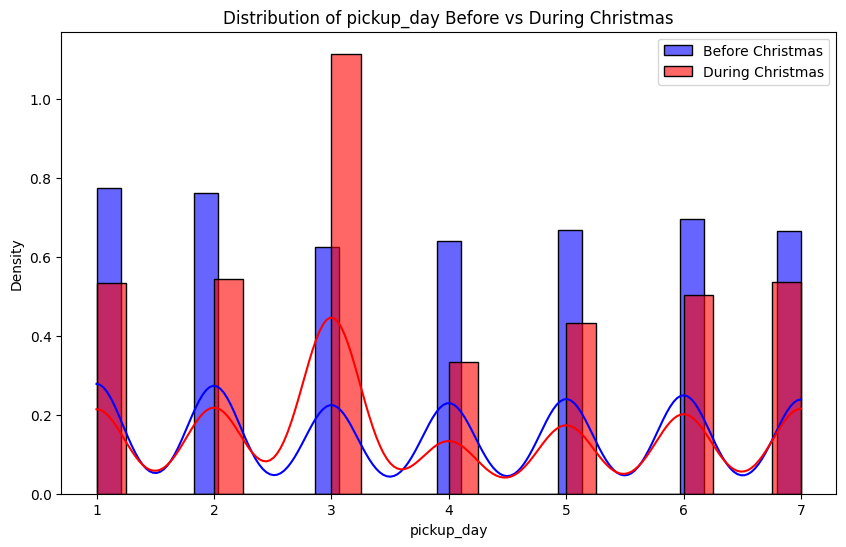

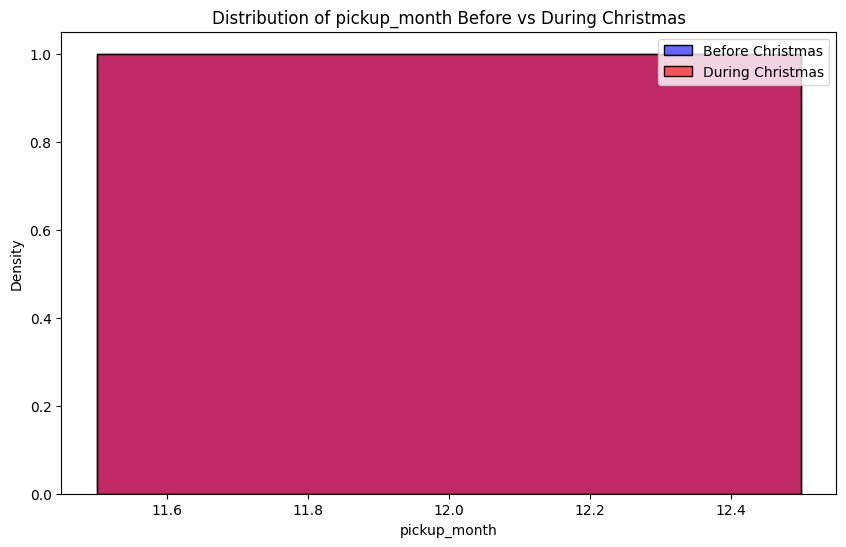

Feature 'pickup_location' not found in one or both datasets.
Feature 'dropoff_location' not found in one or both datasets.
Feature 'payment_method' not found in one or both datasets.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df and df2 are your dataframes for before and during Christmas, respectively
# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# List of numerical and categorical features (adjust these lists according to your data)
numerical_features = ['trip_distance', 'trip_duration', 'pickup_hour', 'pickup_day', 'pickup_month']
categorical_features = ['pickup_location', 'dropoff_location', 'payment_method']  # Example categorical features

# Check the columns in both dataframes
print("Columns in df (before Christmas):", df_pd.columns)
print("Columns in df2 (during Christmas):", df2_pd.columns)

# Plot distribution for numerical features, handling missing columns
for feature in numerical_features:
    if feature in df_pd.columns and feature in df2_pd.columns:
        plt.figure(figsize=(10, 6))

        # Plot for 'before Christmas' data
        sns.histplot(df_pd[feature], kde=True, color='blue', label='Before Christmas', stat='density', alpha=0.6)

        # Plot for 'during Christmas' data
        sns.histplot(df2_pd[feature], kde=True, color='red', label='During Christmas', stat='density', alpha=0.6)

        plt.title(f'Distribution of {feature} Before vs During Christmas')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    else:
        print(f"Feature '{feature}' not found in one or both datasets.")

# Plot count plots for categorical features, handling missing columns
for feature in categorical_features:
    if feature in df_pd.columns and feature in df2_pd.columns:
        plt.figure(figsize=(10, 6))

        # Count plot for 'before Christmas' data
        sns.countplot(x=df_pd[feature], color='blue', alpha=0.6, label='Before Christmas')

        # Count plot for 'during Christmas' data
        sns.countplot(x=df2_pd[feature], color='red', alpha=0.6, label='During Christmas')

        plt.title(f'Count plot of {feature} Before vs During Christmas')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.legend()
        plt.show()
    else:
        print(f"Feature '{feature}' not found in one or both datasets.")


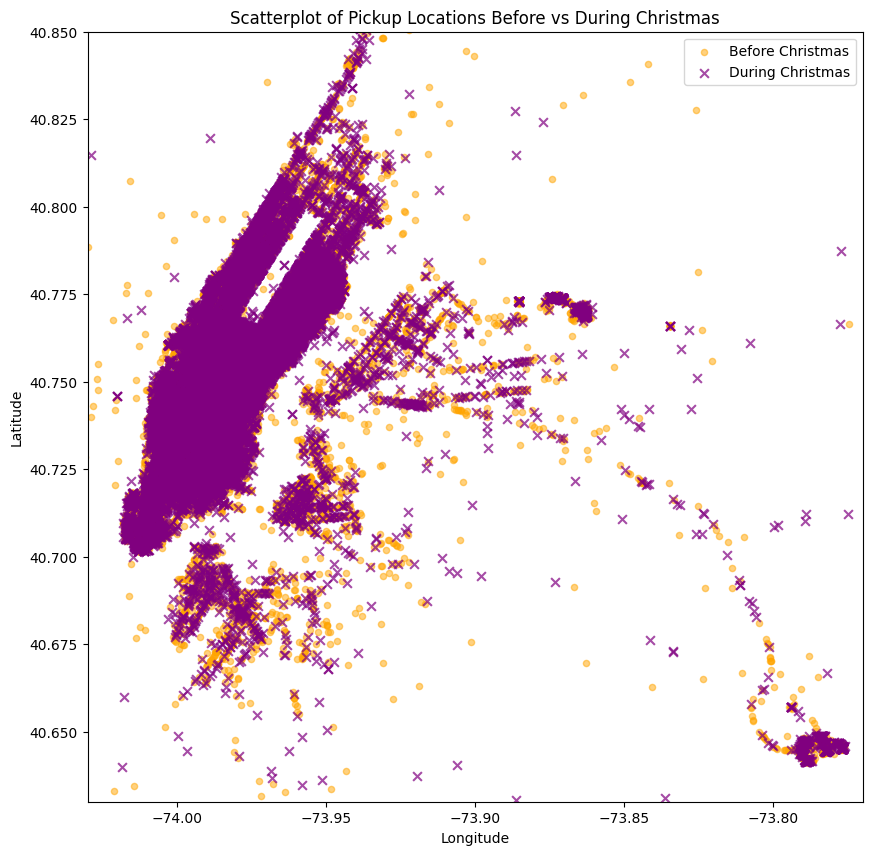

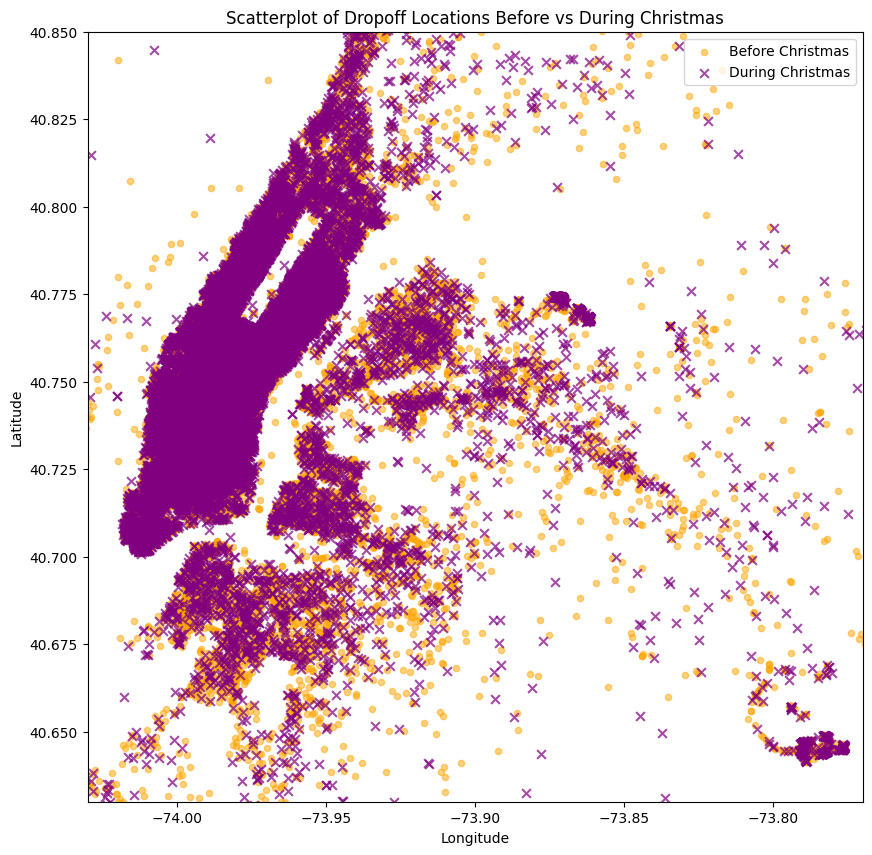

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Check that the required columns exist for scatter plot
required_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

if all(col in df_pd.columns for col in required_columns) and all(col in df2_pd.columns for col in required_columns):
    # Scatter plot for pickup locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))

    # Plot for before Christmas with more distinct color and larger size
    plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], alpha=0.5, s=20, color='orange', label='Before Christmas', marker='o')

    # Plot for during Christmas with more distinct color and larger size
    plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], alpha=0.7, s=40, color='purple', label='During Christmas', marker='x')

    plt.title('Scatterplot of Pickup Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()

    # Scatter plot for dropoff locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))

    # Plot for before Christmas with more distinct color and larger size
    plt.scatter(df_pd['dropoff_longitude'], df_pd['dropoff_latitude'], alpha=0.5, s=20, color='orange', label='Before Christmas', marker='o')

    # Plot for during Christmas with more distinct color and larger size
    plt.scatter(df2_pd['dropoff_longitude'], df2_pd['dropoff_latitude'], alpha=0.7, s=40, color='purple', label='During Christmas', marker='x')

    plt.title('Scatterplot of Dropoff Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()
else:
    print("One or more required columns are missing in the datasets.")


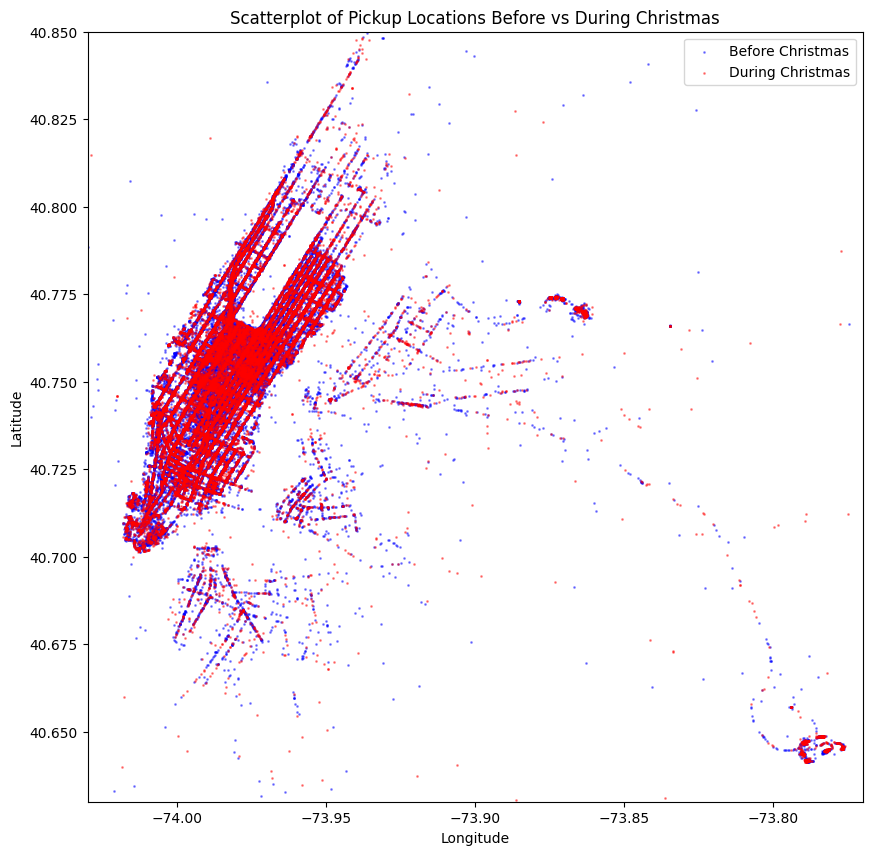

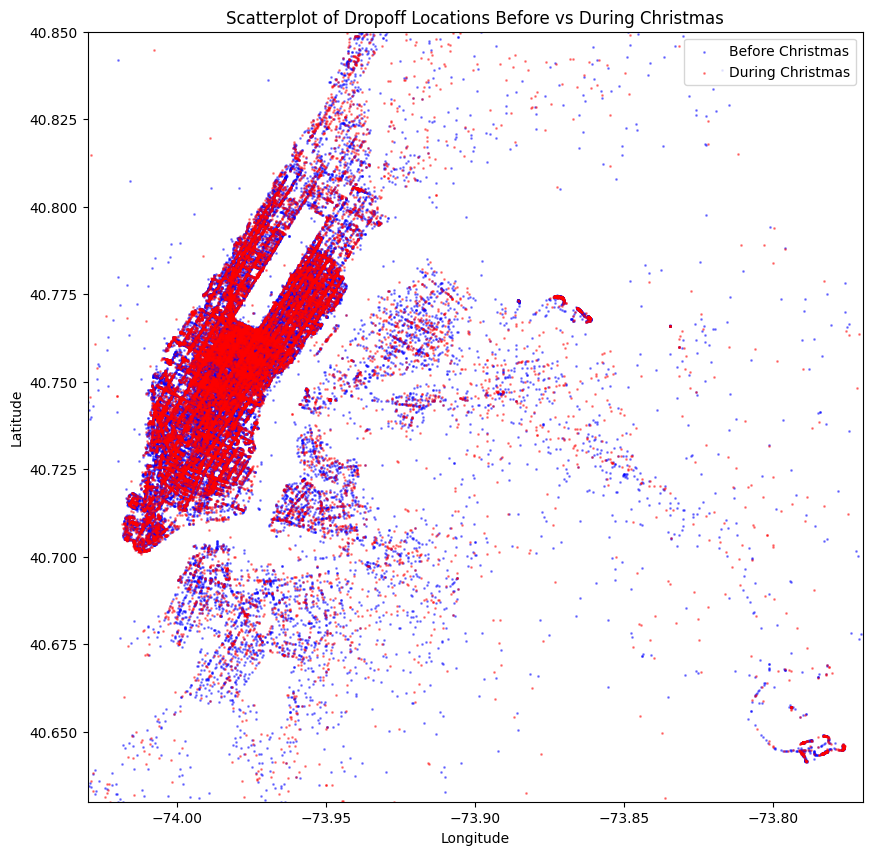

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Check that the required columns exist for scatter plot
required_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

if all(col in df_pd.columns for col in required_columns) and all(col in df2_pd.columns for col in required_columns):
    # Scatter plot for pickup locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], alpha=0.4, s=1, color='blue', label='Before Christmas')
    plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], alpha=0.4, s=1, color='red', label='During Christmas')
    plt.title('Scatterplot of Pickup Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()

    # Scatter plot for dropoff locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pd['dropoff_longitude'], df_pd['dropoff_latitude'], alpha=0.4, s=1, color='blue', label='Before Christmas')
    plt.scatter(df2_pd['dropoff_longitude'], df2_pd['dropoff_latitude'], alpha=0.4, s=1, color='red', label='During Christmas')
    plt.title('Scatterplot of Dropoff Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()
else:
    print("One or more required columns are missing in the datasets.")


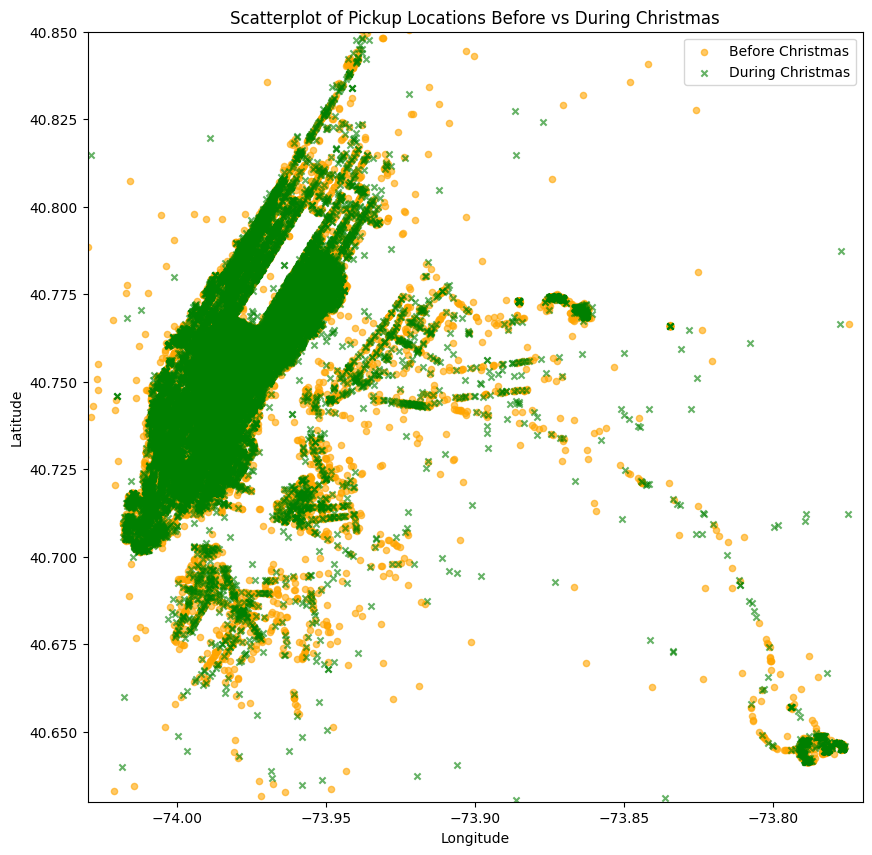

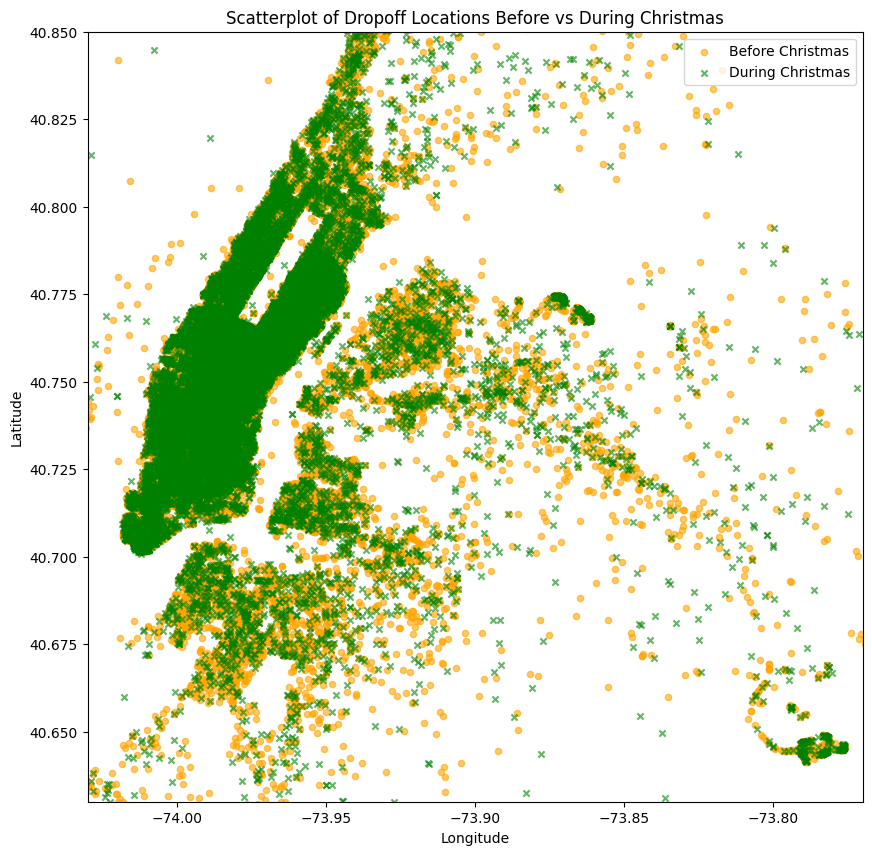

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Check that the required columns exist for scatter plot
required_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

if all(col in df_pd.columns for col in required_columns) and all(col in df2_pd.columns for col in required_columns):
    # Scatter plot for pickup locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], alpha=0.6, s=20, color='orange', label='Before Christmas', marker='o')
    plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], alpha=0.6, s=20, color='green', label='During Christmas', marker='x')
    plt.title('Scatterplot of Pickup Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()

    # Scatter plot for dropoff locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pd['dropoff_longitude'], df_pd['dropoff_latitude'], alpha=0.6, s=20, color='orange', label='Before Christmas', marker='o')
    plt.scatter(df2_pd['dropoff_longitude'], df2_pd['dropoff_latitude'], alpha=0.6, s=20, color='green', label='During Christmas', marker='x')
    plt.title('Scatterplot of Dropoff Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()
else:
    print("One or more required columns are missing in the datasets.")


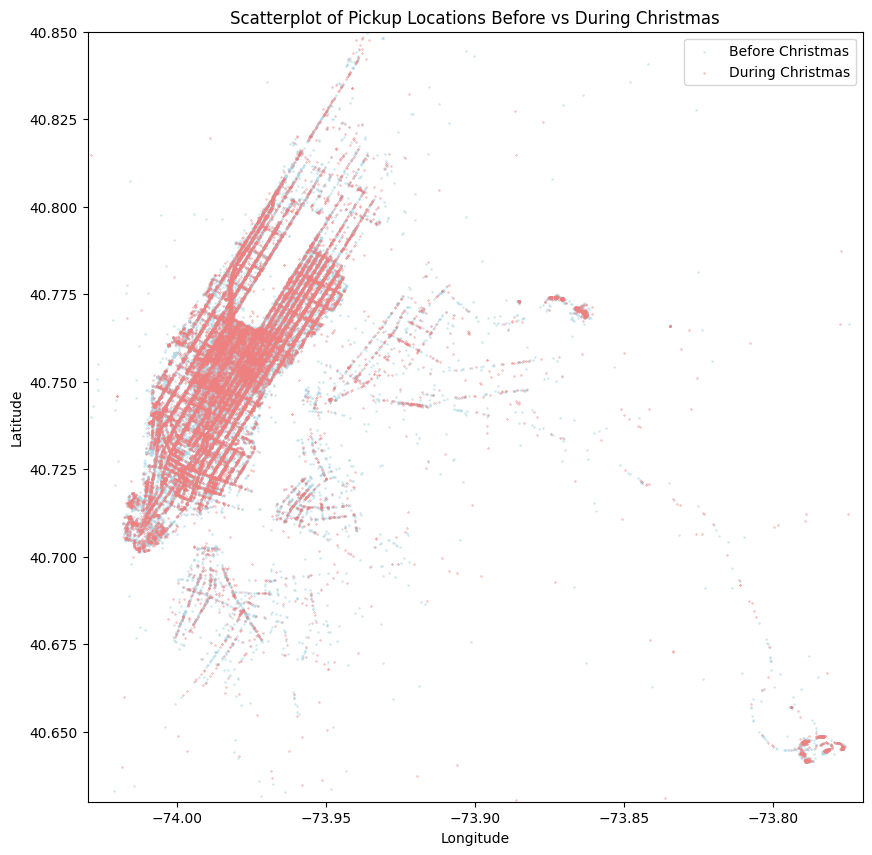

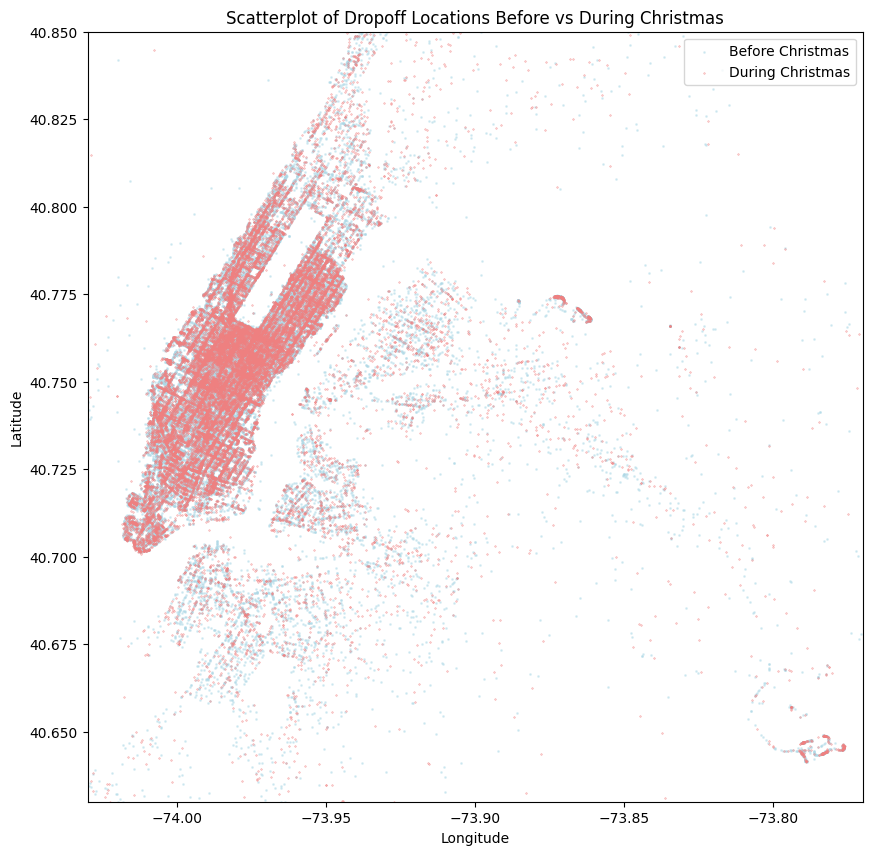

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Check that the required columns exist for scatter plot
required_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

if all(col in df_pd.columns for col in required_columns) and all(col in df2_pd.columns for col in required_columns):
    # Scatter plot for pickup locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], alpha=0.4, s=1, color='lightblue', label='Before Christmas', marker='o')
    plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], alpha=0.4, s=1, color='lightcoral', label='During Christmas', marker='x')
    plt.title('Scatterplot of Pickup Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()

    # Scatter plot for dropoff locations (zoomed in) - comparing before and during Christmas
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pd['dropoff_longitude'], df_pd['dropoff_latitude'], alpha=0.4, s=1, color='lightblue', label='Before Christmas', marker='o')
    plt.scatter(df2_pd['dropoff_longitude'], df2_pd['dropoff_latitude'], alpha=0.4, s=1, color='lightcoral', label='During Christmas', marker='x')
    plt.title('Scatterplot of Dropoff Locations Before vs During Christmas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-74.03, -73.77])  # Zoom into NYC longitude range
    plt.ylim([40.63, 40.85])    # Zoom into NYC latitude range
    plt.legend()
    plt.show()
else:
    print("One or more required columns are missing in the datasets.")


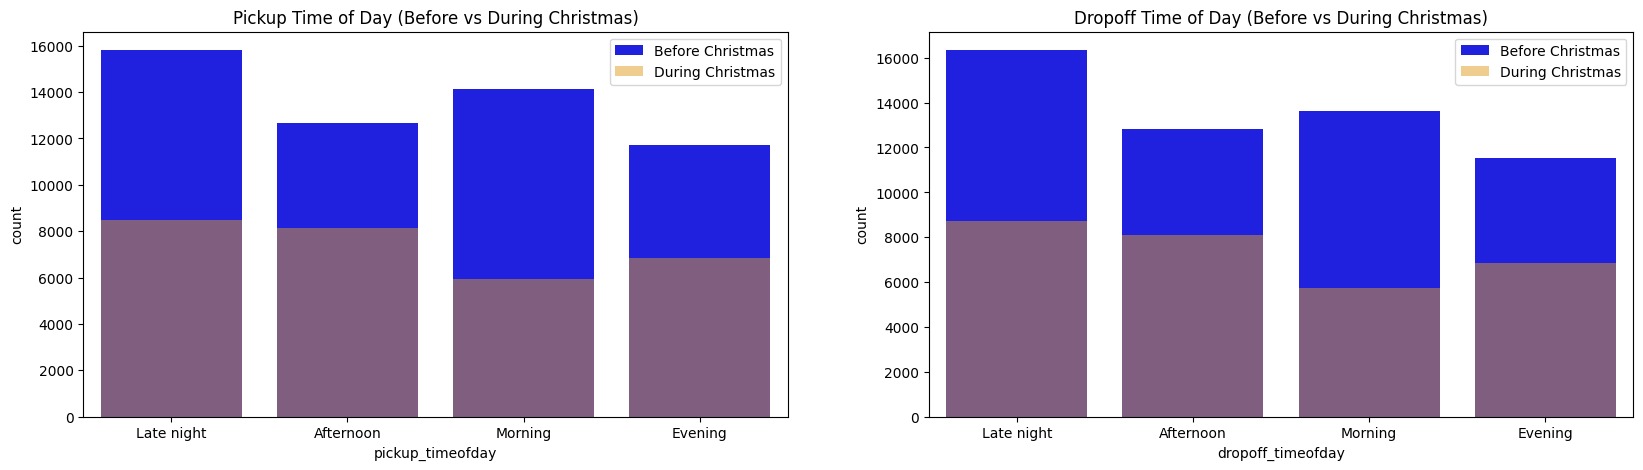

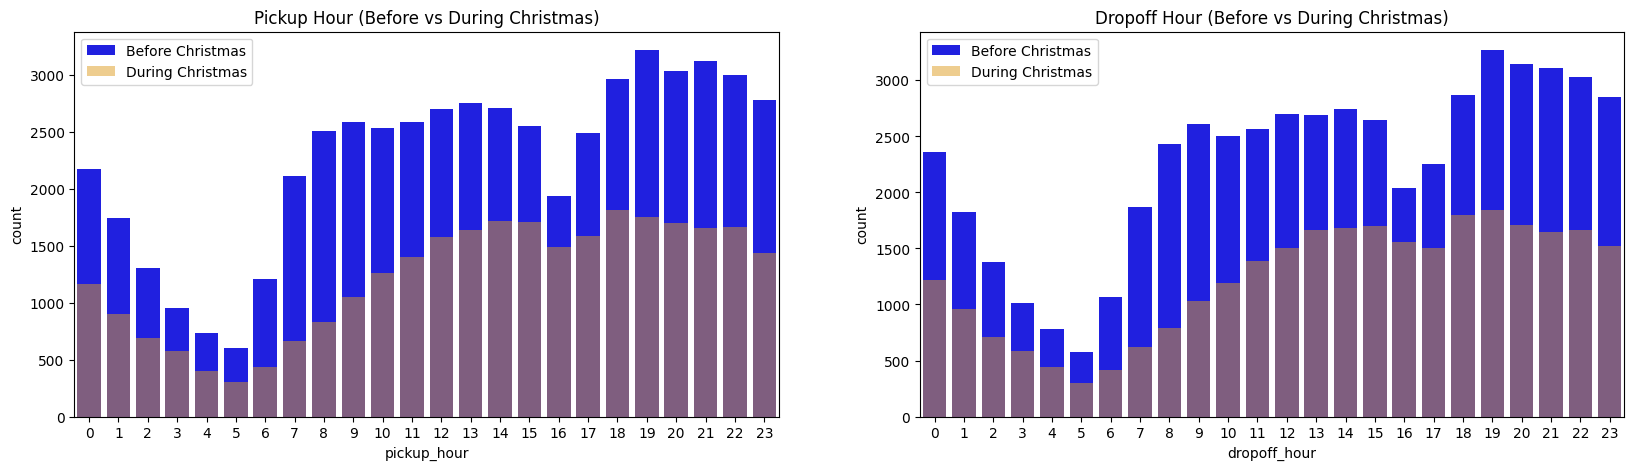

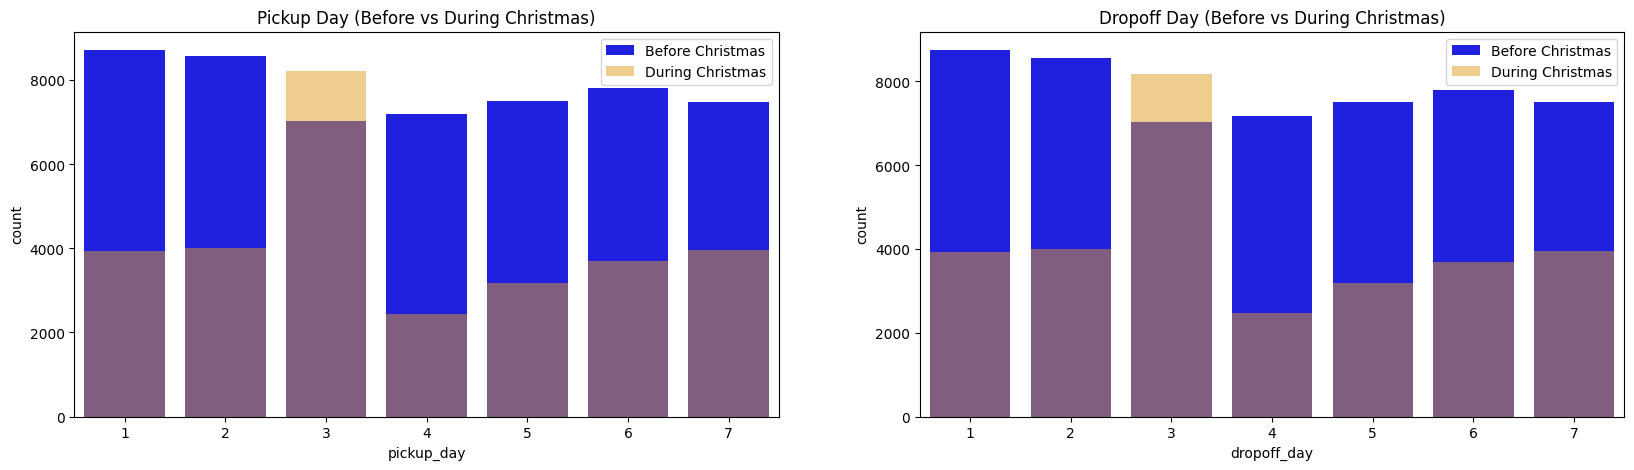

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Set up the figure for Pickup and Dropoff Time of Day
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot Pickup Time of Day
ax1.set_title('Pickup Time of Day (Before vs During Christmas)')
sns.countplot(x="pickup_timeofday", data=df_pd, ax=ax1, color='blue', label='Before Christmas')
sns.countplot(x="pickup_timeofday", data=df2_pd, ax=ax1, color='orange', label='During Christmas', alpha=0.5)
ax1.legend()

# Plot Dropoff Time of Day
ax2.set_title('Dropoff Time of Day (Before vs During Christmas)')
sns.countplot(x="dropoff_timeofday", data=df_pd, ax=ax2, color='blue', label='Before Christmas')
sns.countplot(x="dropoff_timeofday", data=df2_pd, ax=ax2, color='orange', label='During Christmas', alpha=0.5)
ax2.legend()

plt.show()

# Set up the figure for Pickup and Dropoff Hours
fig, (ax3, ax4) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot Pickup Hour
ax3.set_title('Pickup Hour (Before vs During Christmas)')
sns.countplot(x="pickup_hour", data=df_pd, ax=ax3, color='blue', label='Before Christmas')
sns.countplot(x="pickup_hour", data=df2_pd, ax=ax3, color='orange', label='During Christmas', alpha=0.5)
ax3.legend()

# Plot Dropoff Hour
ax4.set_title('Dropoff Hour (Before vs During Christmas)')
sns.countplot(x="dropoff_hour", data=df_pd, ax=ax4, color='blue', label='Before Christmas')
sns.countplot(x="dropoff_hour", data=df2_pd, ax=ax4, color='orange', label='During Christmas', alpha=0.5)
ax4.legend()

plt.show()

# Set up the figure for Pickup and Dropoff Days
fig, (ax5, ax6) = plt.subplots(ncols=2, figsize=(20, 5))

# Plot Pickup Day
ax5.set_title('Pickup Day (Before vs During Christmas)')
sns.countplot(x="pickup_day", data=df_pd, ax=ax5, color='blue', label='Before Christmas')
sns.countplot(x="pickup_day", data=df2_pd, ax=ax5, color='orange', label='During Christmas', alpha=0.5)
ax5.legend()

# Plot Dropoff Day
ax6.set_title('Dropoff Day (Before vs During Christmas)')
sns.countplot(x="dropoff_day", data=df_pd, ax=ax6, color='blue', label='Before Christmas')
sns.countplot(x="dropoff_day", data=df2_pd, ax=ax6, color='orange', label='During Christmas', alpha=0.5)
ax6.legend()

plt.show()


# Bivariate Analysis

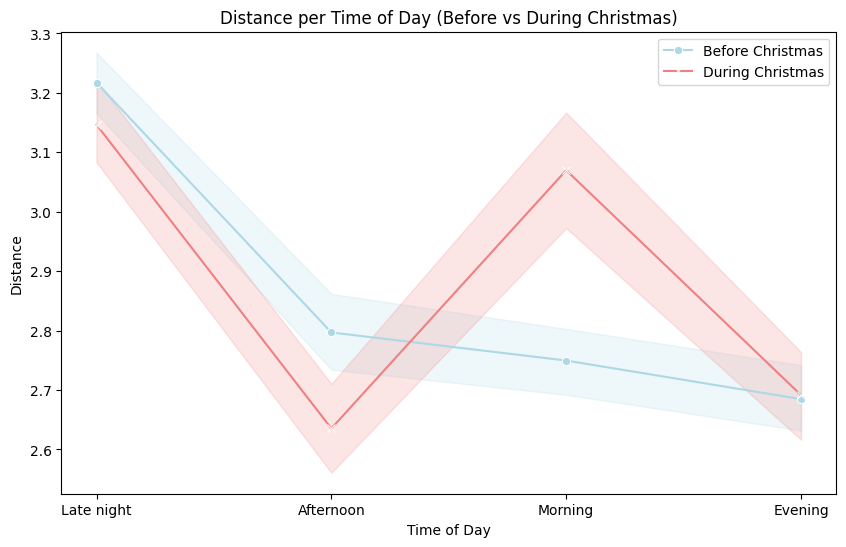

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Plot for both before and during Christmas
plt.figure(figsize=(10, 6))

# Line plot for 'Before Christmas'
sns.lineplot(x='pickup_timeofday', y='trip_distance', data=df_pd, label='Before Christmas', color='blue', marker='o')

# Line plot for 'During Christmas'
sns.lineplot(x='pickup_timeofday', y='trip_distance', data=df2_pd, label='During Christmas', color='red', marker='x')

plt.title('Distance per Time of Day (Before vs During Christmas)')
plt.xlabel('Time of Day')
plt.ylabel('Distance')
plt.legend()
plt.show()


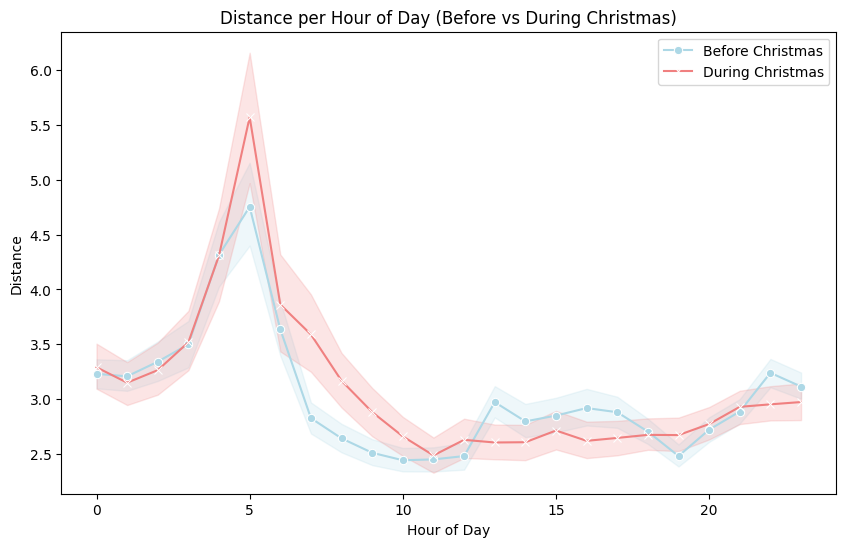

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Plot for both before and during Christmas
plt.figure(figsize=(10, 6))

# Line plot for 'Before Christmas'
sns.lineplot(x='pickup_hour', y='trip_distance', data=df_pd, label='Before Christmas', color='blue', marker='o')

# Line plot for 'During Christmas'
sns.lineplot(x='pickup_hour', y='trip_distance', data=df2_pd, label='During Christmas', color='red', marker='x')

plt.title('Distance per Hour of Day (Before vs During Christmas)')
plt.xlabel('Hour of Day')
plt.ylabel('Distance')
plt.legend()
plt.show()


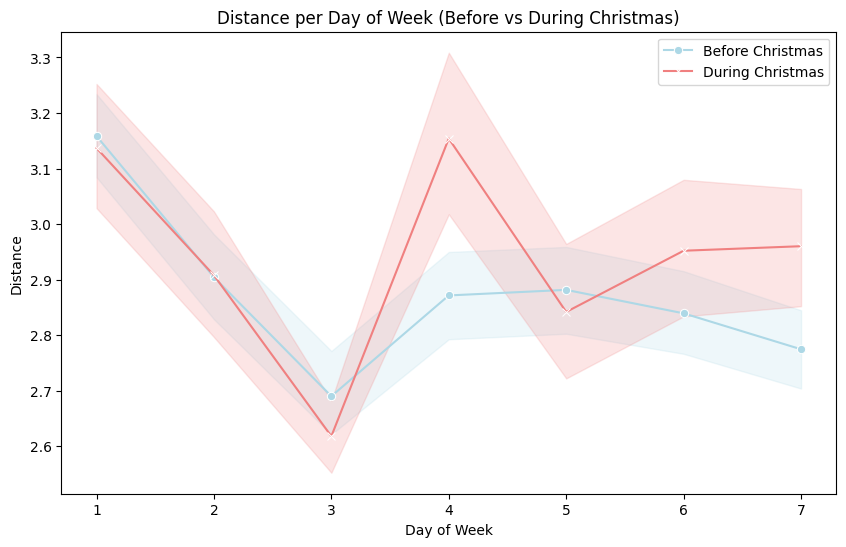

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Plot for both before and during Christmas
plt.figure(figsize=(10, 6))

# Line plot for 'Before Christmas'
sns.lineplot(x='pickup_day', y='trip_distance', data=df_pd, label='Before Christmas', color='blue', marker='o')

# Line plot for 'During Christmas'
sns.lineplot(x='pickup_day', y='trip_distance', data=df2_pd, label='During Christmas', color='red', marker='x')

plt.title('Distance per Day of Week (Before vs During Christmas)')
plt.xlabel('Day of Week')
plt.ylabel('Distance')
plt.legend()
plt.show()


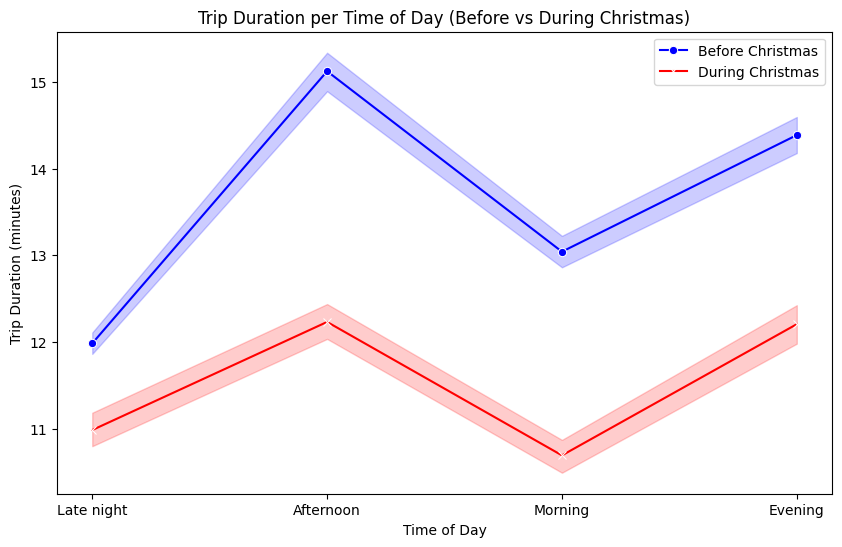

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Plot for both before and during Christmas
plt.figure(figsize=(10, 6))

# Line plot for 'Before Christmas'
sns.lineplot(x='pickup_timeofday', y='trip_duration', data=df_pd, label='Before Christmas', color='blue', marker='o')

# Line plot for 'During Christmas'
sns.lineplot(x='pickup_timeofday', y='trip_duration', data=df2_pd, label='During Christmas', color='red', marker='x')

plt.title('Trip Duration per Time of Day (Before vs During Christmas)')
plt.xlabel('Time of Day')
plt.ylabel('Trip Duration (minutes)')
plt.legend()
plt.show()


<ipython-input-121-e5eb30ecbf55>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df_pd[['pickup_longitude', 'pickup_latitude']])


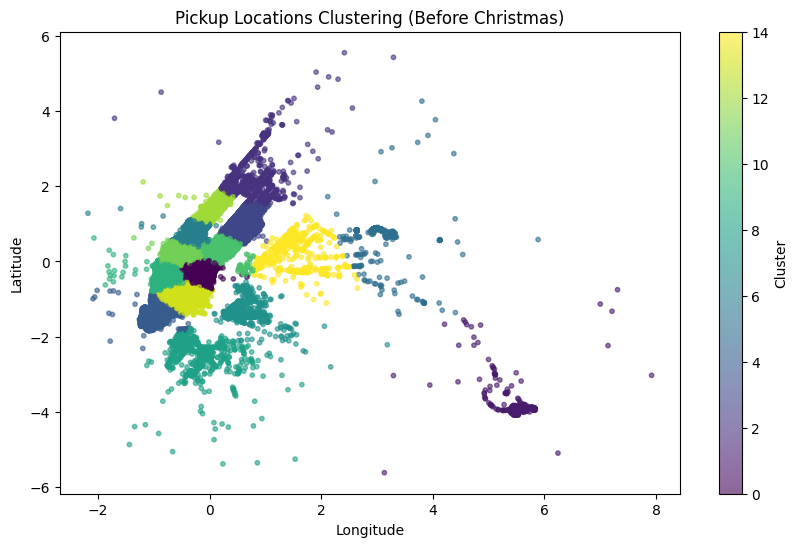

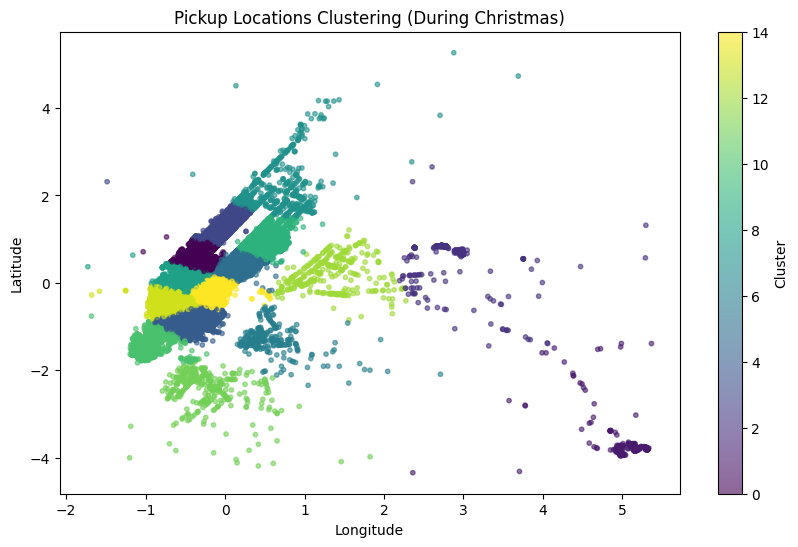

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Filter data to focus on New York City region
df_pd = df_pd[(df_pd['pickup_longitude'] > -74.05) & (df_pd['pickup_longitude'] < -73.7) &
              (df_pd['pickup_latitude'] > 40.6) & (df_pd['pickup_latitude'] < 40.9)]

df2_pd = df2_pd[(df2_pd['pickup_longitude'] > -74.05) & (df2_pd['pickup_longitude'] < -73.7) &
                (df2_pd['pickup_latitude'] > 40.6) & (df2_pd['pickup_latitude'] < 40.9)]

# Normalize the latitude and longitude values for clustering
scaler = StandardScaler()
df_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df_pd[['pickup_longitude', 'pickup_latitude']])
df2_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df2_pd[['pickup_longitude', 'pickup_latitude']])

# Define the number of clusters
n_clusters = 15

# Perform KMeans clustering on the pickup locations (Before Christmas) with explicit n_init
kmeans_pickup_before = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df_pd['pickup_cluster'] = kmeans_pickup_before.fit_predict(df_pd[['pickup_longitude', 'pickup_latitude']])

# Perform KMeans clustering on the pickup locations (During Christmas) with explicit n_init
kmeans_pickup_during = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df2_pd['pickup_cluster'] = kmeans_pickup_during.fit_predict(df2_pd[['pickup_longitude', 'pickup_latitude']])

# Plot Pickup Clusters Before Christmas
plt.figure(figsize=(10, 6))
plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], c=df_pd['pickup_cluster'], cmap='viridis', s=10, alpha=0.6)
plt.title('Pickup Locations Clustering (Before Christmas)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Plot Pickup Clusters During Christmas
plt.figure(figsize=(10, 6))
plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], c=df2_pd['pickup_cluster'], cmap='viridis', s=10, alpha=0.6)
plt.title('Pickup Locations Clustering (During Christmas)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


<ipython-input-122-c1d218f034c3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df_pd[['pickup_longitude', 'pickup_latitude']])


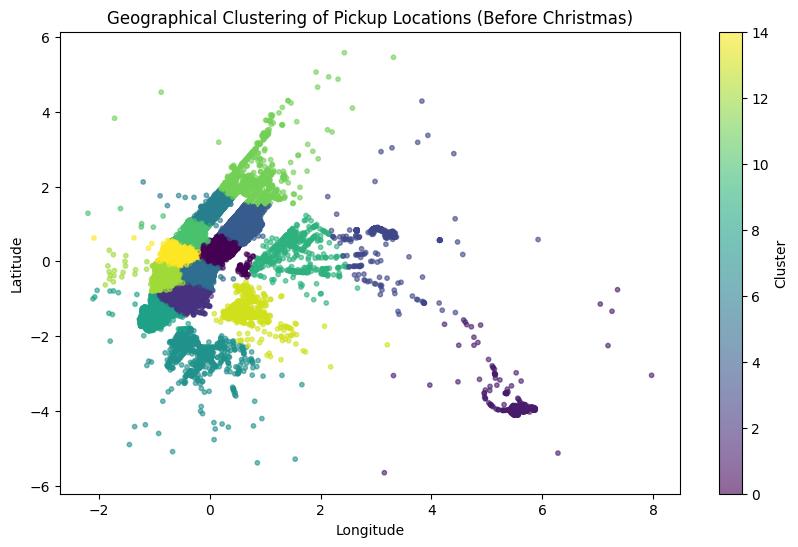

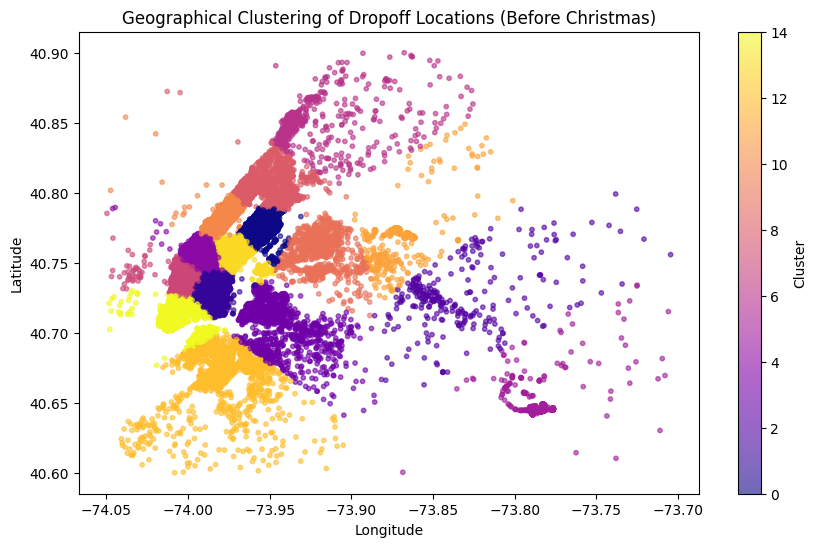

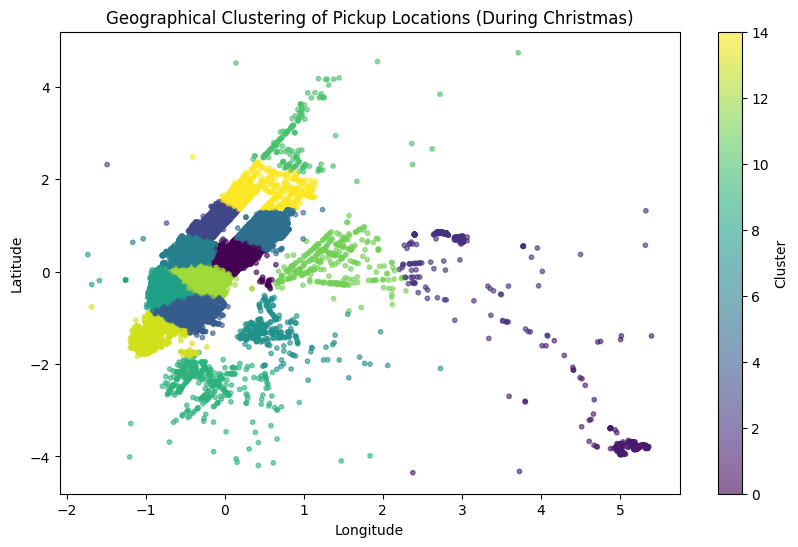

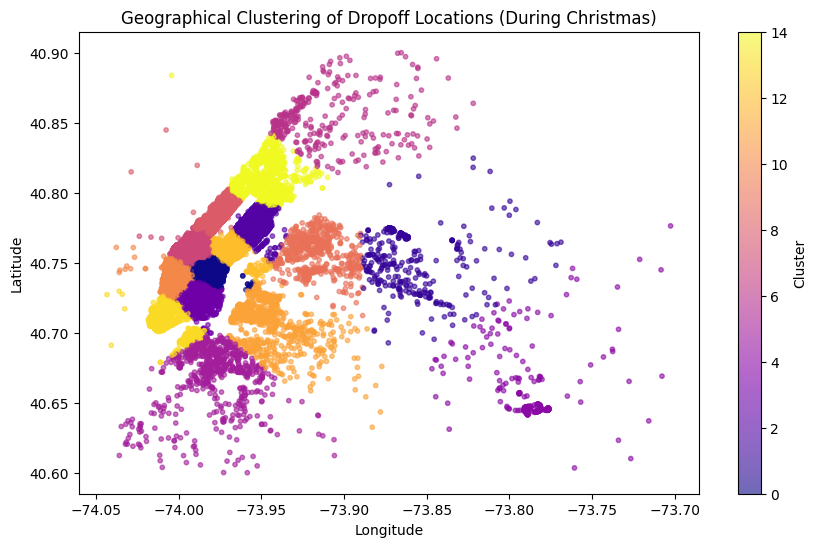

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Filter data to focus on New York City region (for both pickup and drop-off locations)
df_pd = df_pd[(df_pd['pickup_longitude'] > -74.05) & (df_pd['pickup_longitude'] < -73.7) &
              (df_pd['pickup_latitude'] > 40.6) & (df_pd['pickup_latitude'] < 40.9) &
              (df_pd['dropoff_longitude'] > -74.05) & (df_pd['dropoff_longitude'] < -73.7) &
              (df_pd['dropoff_latitude'] > 40.6) & (df_pd['dropoff_latitude'] < 40.9)]

df2_pd = df2_pd[(df2_pd['pickup_longitude'] > -74.05) & (df2_pd['pickup_longitude'] < -73.7) &
                (df2_pd['pickup_latitude'] > 40.6) & (df2_pd['pickup_latitude'] < 40.9) &
                (df2_pd['dropoff_longitude'] > -74.05) & (df2_pd['dropoff_longitude'] < -73.7) &
                (df2_pd['dropoff_latitude'] > 40.6) & (df2_pd['dropoff_latitude'] < 40.9)]

# Normalize the latitude and longitude values for clustering
scaler = StandardScaler()
df_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df_pd[['pickup_longitude', 'pickup_latitude']])
df2_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df2_pd[['pickup_longitude', 'pickup_latitude']])

# Define the number of clusters (15 for more granularity in identifying regions)
n_clusters = 15

# Perform KMeans clustering on the pickup locations (Before Christmas) with explicit n_init
kmeans_pickup_before = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df_pd['pickup_cluster'] = kmeans_pickup_before.fit_predict(df_pd[['pickup_longitude', 'pickup_latitude']])

# Perform KMeans clustering on the dropoff locations (Before Christmas)
kmeans_dropoff_before = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df_pd['dropoff_cluster'] = kmeans_dropoff_before.fit_predict(df_pd[['dropoff_longitude', 'dropoff_latitude']])

# Perform KMeans clustering on the pickup locations (During Christmas)
kmeans_pickup_during = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df2_pd['pickup_cluster'] = kmeans_pickup_during.fit_predict(df2_pd[['pickup_longitude', 'pickup_latitude']])

# Perform KMeans clustering on the dropoff locations (During Christmas)
kmeans_dropoff_during = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df2_pd['dropoff_cluster'] = kmeans_dropoff_during.fit_predict(df2_pd[['dropoff_longitude', 'dropoff_latitude']])

# Plot Pickup Clusters Before Christmas
plt.figure(figsize=(10, 6))
plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], c=df_pd['pickup_cluster'], cmap='viridis', s=10, alpha=0.6)
plt.title('Geographical Clustering of Pickup Locations (Before Christmas)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Plot Dropoff Clusters Before Christmas
plt.figure(figsize=(10, 6))
plt.scatter(df_pd['dropoff_longitude'], df_pd['dropoff_latitude'], c=df_pd['dropoff_cluster'], cmap='plasma', s=10, alpha=0.6)
plt.title('Geographical Clustering of Dropoff Locations (Before Christmas)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Plot Pickup Clusters During Christmas
plt.figure(figsize=(10, 6))
plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], c=df2_pd['pickup_cluster'], cmap='viridis', s=10, alpha=0.6)
plt.title('Geographical Clustering of Pickup Locations (During Christmas)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Plot Dropoff Clusters During Christmas
plt.figure(figsize=(10, 6))
plt.scatter(df2_pd['dropoff_longitude'], df2_pd['dropoff_latitude'], c=df2_pd['dropoff_cluster'], cmap='plasma', s=10, alpha=0.6)
plt.title('Geographical Clustering of Dropoff Locations (During Christmas)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


<ipython-input-124-19e898527bb6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df_pd[['pickup_longitude', 'pickup_latitude']])


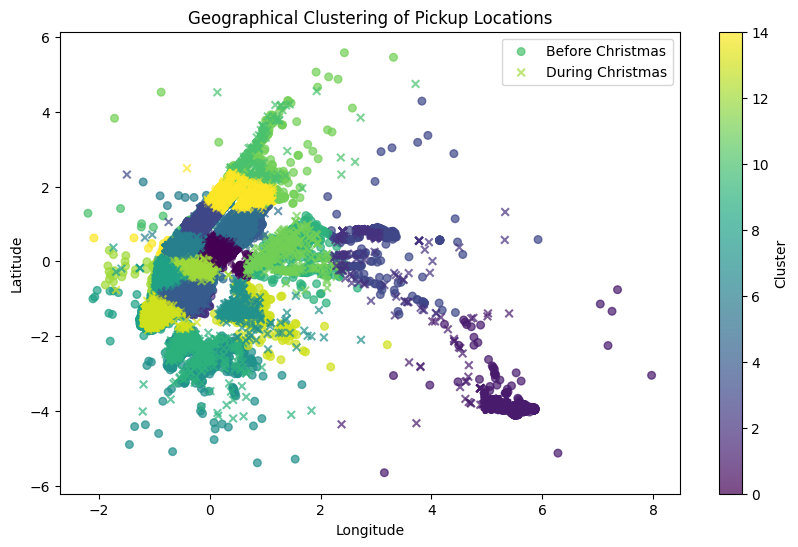

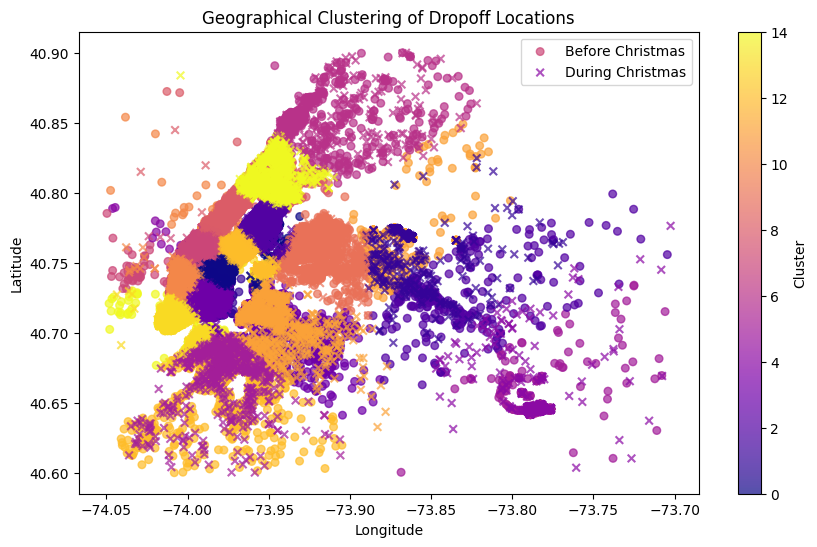

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Convert to Pandas if needed
df_pd = df.toPandas()    # Data before Christmas
df2_pd = df2.toPandas()  # Data during Christmas holidays

# Filter data to focus on New York City region (for both pickup and drop-off locations)
df_pd = df_pd[(df_pd['pickup_longitude'] > -74.05) & (df_pd['pickup_longitude'] < -73.7) &
              (df_pd['pickup_latitude'] > 40.6) & (df_pd['pickup_latitude'] < 40.9) &
              (df_pd['dropoff_longitude'] > -74.05) & (df_pd['dropoff_longitude'] < -73.7) &
              (df_pd['dropoff_latitude'] > 40.6) & (df_pd['dropoff_latitude'] < 40.9)]

df2_pd = df2_pd[(df2_pd['pickup_longitude'] > -74.05) & (df2_pd['pickup_longitude'] < -73.7) &
                (df2_pd['pickup_latitude'] > 40.6) & (df2_pd['pickup_latitude'] < 40.9) &
                (df2_pd['dropoff_longitude'] > -74.05) & (df2_pd['dropoff_longitude'] < -73.7) &
                (df2_pd['dropoff_latitude'] > 40.6) & (df2_pd['dropoff_latitude'] < 40.9)]

# Normalize the latitude and longitude values for clustering
scaler = StandardScaler()
df_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df_pd[['pickup_longitude', 'pickup_latitude']])
df2_pd[['pickup_longitude', 'pickup_latitude']] = scaler.fit_transform(df2_pd[['pickup_longitude', 'pickup_latitude']])

# Define the number of clusters (15 for more granularity in identifying regions)
n_clusters = 15

# Perform KMeans clustering on the pickup and dropoff locations for both before and during Christmas
kmeans_pickup = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df_pd['pickup_cluster'] = kmeans_pickup.fit_predict(df_pd[['pickup_longitude', 'pickup_latitude']])
df2_pd['pickup_cluster'] = kmeans_pickup.fit_predict(df2_pd[['pickup_longitude', 'pickup_latitude']])

kmeans_dropoff = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df_pd['dropoff_cluster'] = kmeans_dropoff.fit_predict(df_pd[['dropoff_longitude', 'dropoff_latitude']])
df2_pd['dropoff_cluster'] = kmeans_dropoff.fit_predict(df2_pd[['dropoff_longitude', 'dropoff_latitude']])

# Plot Pickup Clusters for both periods on the same plot
plt.figure(figsize=(10, 6))

# Plot 'Before Christmas' data with 'o' marker and larger size
plt.scatter(df_pd['pickup_longitude'], df_pd['pickup_latitude'], c=df_pd['pickup_cluster'], cmap='viridis',
            s=30, alpha=0.7, marker='o', label='Before Christmas')

# Plot 'During Christmas' data with 'x' marker and larger size
plt.scatter(df2_pd['pickup_longitude'], df2_pd['pickup_latitude'], c=df2_pd['pickup_cluster'], cmap='viridis',
            s=30, alpha=0.7, marker='x', label='During Christmas')

plt.title('Geographical Clustering of Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

# Plot Dropoff Clusters for both periods on the same plot
plt.figure(figsize=(10, 6))

# Plot 'Before Christmas' data with 'o' marker and larger size
plt.scatter(df_pd['dropoff_longitude'], df_pd['dropoff_latitude'], c=df_pd['dropoff_cluster'], cmap='plasma',
            s=30, alpha=0.7, marker='o', label='Before Christmas')

# Plot 'During Christmas' data with 'x' marker and larger size
plt.scatter(df2_pd['dropoff_longitude'], df2_pd['dropoff_latitude'], c=df2_pd['dropoff_cluster'], cmap='plasma',
            s=30, alpha=0.7, marker='x', label='During Christmas')

plt.title('Geographical Clustering of Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


# Sarimax

In [ ]:
# Check the columns in df and df2
print(df.columns)
print(df2.columns)


Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_day_of_week', 'trip_duration', 'dropoff_hour', 'dropoff_day',
       'pickup_timeofday', 'dropoff_timeofday'],
      dtype='object')
Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_day_of_week', 'trip_duration', 'dropoff_hour', 'dropoff_day',
       'pickup_timeofday', 'dropoff_timeofday'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Before Christmas In-sample RMSE: 10.441730404334454


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Before Christmas Out-of-sample RMSE: 12.486988376607012


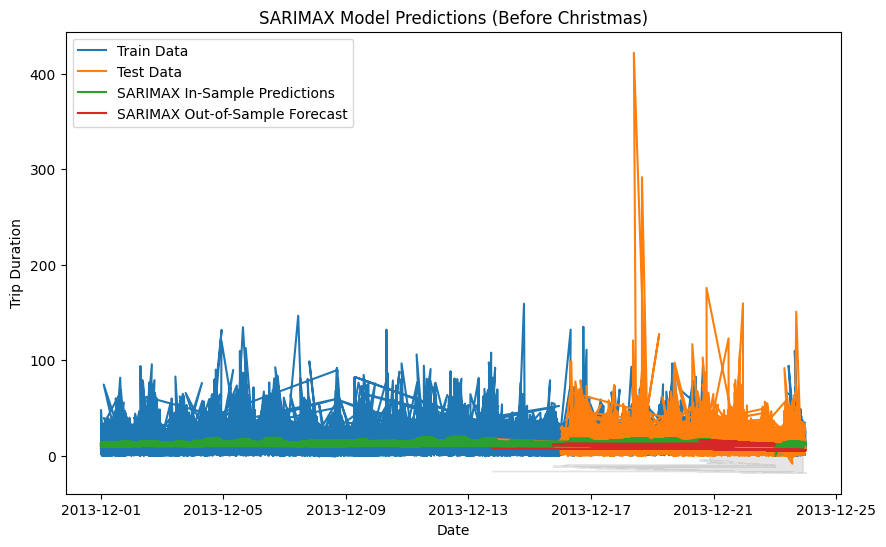

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

During Christmas In-sample RMSE: 14.84628980446924
During Christmas Out-of-sample RMSE: 13.746375871678572


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


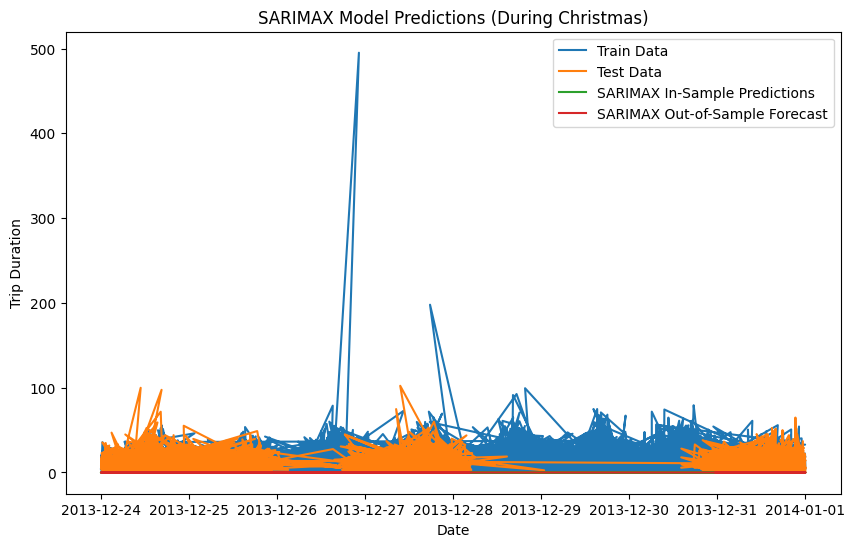

Before Christmas - In-sample RMSE: 10.441730404334454, Out-of-sample RMSE: 12.486988376607012
During Christmas - In-sample RMSE: 14.84628980446924, Out-of-sample RMSE: 13.746375871678572


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import math

# Use 'pickup_datetime' as the time index
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df2['pickup_datetime'] = pd.to_datetime(df2['pickup_datetime'])

# Set the 'pickup_datetime' column as the index for both datasets
df.set_index('pickup_datetime', inplace=True)
df2.set_index('pickup_datetime', inplace=True)

# Function to apply SARIMAX and evaluate RMSE
def apply_sarimax(train_data, test_data, title):
    # Fit the SARIMAX model
    order = (1, 0, 1)
    seasonal_order = (1, 0, 1, 7)

    model = SARIMAX(train_data['trip_duration'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # In-sample predictions and RMSE calculation
    train_pred = model_fit.predict(start=0, end=len(train_data) - 1)
    train_rmse = math.sqrt(mean_squared_error(train_data['trip_duration'], train_pred))
    print(f'{title} In-sample RMSE: {train_rmse}')

    # Out-of-sample forecasting and RMSE calculation
    test_pred = model_fit.get_forecast(steps=len(test_data))
    test_pred_ci = test_pred.conf_int()
    test_rmse = math.sqrt(mean_squared_error(test_data['trip_duration'], test_pred.predicted_mean))
    print(f'{title} Out-of-sample RMSE: {test_rmse}')

    # Plot the in-sample fit and the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data['trip_duration'], label='Train Data')
    plt.plot(test_data.index, test_data['trip_duration'], label='Test Data')
    plt.plot(train_data.index, train_pred, label='SARIMAX In-Sample Predictions')
    plt.plot(test_data.index, test_pred.predicted_mean, label='SARIMAX Out-of-Sample Forecast')
    plt.fill_between(test_data.index, test_pred_ci.iloc[:, 0], test_pred_ci.iloc[:, 1], color='gray', alpha=0.2)
    plt.title(f'SARIMAX Model Predictions ({title})')
    plt.xlabel('Date')
    plt.ylabel('Trip Duration')
    plt.legend()
    plt.show()

    return train_rmse, test_rmse

# Split both df and df2 into training (80%) and testing (20%) sets
train_size_df = int(len(df) * 0.8)
train_df, test_df = df[:train_size_df], df[train_size_df:]

train_size_df2 = int(len(df2) * 0.8)
train_df2, test_df2 = df2[:train_size_df2], df2[train_size_df2:]

# Apply SARIMAX model for "Before Christmas"
train_rmse_df, test_rmse_df = apply_sarimax(train_df, test_df, title="Before Christmas")

# Apply SARIMAX model for "During Christmas"
train_rmse_df2, test_rmse_df2 = apply_sarimax(train_df2, test_df2, title="During Christmas")

# Print final RMSE values for comparison
print(f"Before Christmas - In-sample RMSE: {train_rmse_df}, Out-of-sample RMSE: {test_rmse_df}")
print(f"During Christmas - In-sample RMSE: {train_rmse_df2}, Out-of-sample RMSE: {test_rmse_df2}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure the 'pickup_datetime' is set as the index for both datasets
df.set_index('pickup_datetime', inplace=True)
df2.set_index('pickup_datetime', inplace=True)

# Perform seasonal decomposition for both df and df2
decomposition_df = seasonal_decompose(df['trip_duration'], model='additive', period=7)
decomposition_df2 = seasonal_decompose(df2['trip_duration'], model='additive', period=7)

# De-trended time series (subtract the trend)
detrended_df = df['trip_duration'] - decomposition_df.trend
detrended_df2 = df2['trip_duration'] - decomposition_df2.trend

# Create the layout for multiple plots for both datasets
fig, axs = plt.subplots(4, 2, figsize=(14, 10))

# Plot 1: De-trended Time Series (Before Christmas)
axs[0, 0].plot(df.index, detrended_df, label='De-Trended Time Series', color='blue')
axs[0, 0].set_title('De-Trended Time Series (Before Christmas)')
axs[0, 0].legend()

# Plot 2: De-trended Time Series (During Christmas)
axs[0, 1].plot(df2.index, detrended_df2, label='De-Trended Time Series', color='green')
axs[0, 1].set_title('De-Trended Time Series (During Christmas)')
axs[0, 1].legend()

# Plot 3: Histogram of the original time series (Before Christmas)
axs[1, 0].hist(df['trip_duration'], bins=20, color='blue')
axs[1, 0].set_title('Histogram of Trip Duration (Before Christmas)')
axs[1, 0].set_xlabel('Trip Duration')
axs[1, 0].set_ylabel('Frequency')

# Plot 4: Histogram of the original time series (During Christmas)
axs[1, 1].hist(df2['trip_duration'], bins=20, color='green')
axs[1, 1].set_title('Histogram of Trip Duration (During Christmas)')
axs[1, 1].set_xlabel('Trip Duration')
axs[1, 1].set_ylabel('Frequency')

# Plot 5: Autocorrelation plot (Before Christmas)
plot_acf(detrended_df.dropna(), ax=axs[2, 0], lags=12)
axs[2, 0].set_title('Autocorrelation (Before Christmas)')

# Plot 6: Autocorrelation plot (During Christmas)
plot_acf(detrended_df2.dropna(), ax=axs[2, 1], lags=12)
axs[2, 1].set_title('Autocorrelation (During Christmas)')

# Plot 7: Partial Autocorrelation plot (Before Christmas)
plot_pacf(detrended_df.dropna(), ax=axs[3, 0], lags=12)
axs[3, 0].set_title('Partial Autocorrelation (Before Christmas)')

# Plot 8: Partial Autocorrelation plot (During Christmas)
plot_pacf(detrended_df2.dropna(), ax=axs[3, 1], lags=12)
axs[3, 1].set_title('Partial Autocorrelation (During Christmas)')

plt.tight_layout()
plt.show()


KeyError: "None of ['pickup_datetime'] are in the columns"

In [ ]:
print(df.columns)
print(df2.columns)


Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'pickup_hour', 'pickup_day', 'pickup_month', 'pickup_day_of_week',
       'trip_duration', 'dropoff_hour', 'dropoff_day', 'pickup_timeofday',
       'dropoff_timeofday'],
      dtype='object')
Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'pickup_hour', 'pickup_day', 'pickup_month', 'pickup_day_of_week',
       'trip_duration', 'dropoff_hour', 'dropoff_day', 'pickup_timeofday',
       'dropoff_timeofday'],
      dtype='object')


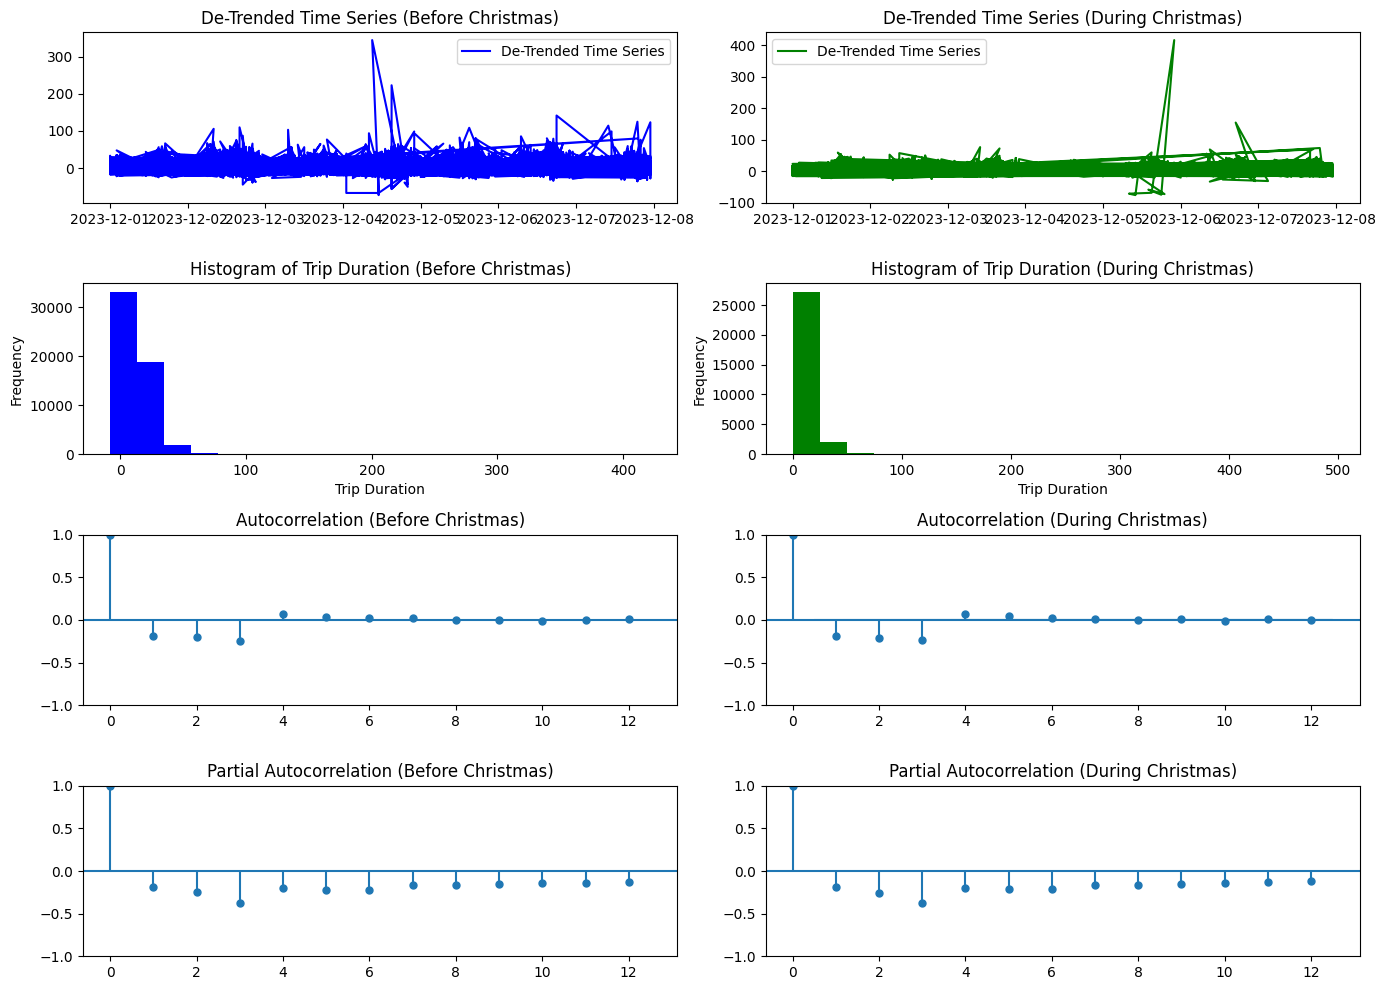

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create 'pickup_datetime' from the existing 'pickup_day', 'pickup_month', and 'pickup_hour'
# Assuming the year is 2023 (you can adjust as needed)
df['pickup_datetime'] = pd.to_datetime(
    {'year': 2023, 'month': df['pickup_month'], 'day': df['pickup_day'], 'hour': df['pickup_hour']}
)

df2['pickup_datetime'] = pd.to_datetime(
    {'year': 2023, 'month': df2['pickup_month'], 'day': df2['pickup_day'], 'hour': df2['pickup_hour']}
)

# Now set the 'pickup_datetime' column as the index for both datasets
df.set_index('pickup_datetime', inplace=True)
df2.set_index('pickup_datetime', inplace=True)

# Perform seasonal decomposition for both df and df2
decomposition_df = seasonal_decompose(df['trip_duration'], model='additive', period=7)
decomposition_df2 = seasonal_decompose(df2['trip_duration'], model='additive', period=7)

# De-trended time series (subtract the trend)
detrended_df = df['trip_duration'] - decomposition_df.trend
detrended_df2 = df2['trip_duration'] - decomposition_df2.trend

# Create the layout for multiple plots for both datasets
fig, axs = plt.subplots(4, 2, figsize=(14, 10))

# Plot 1: De-trended Time Series (Before Christmas)
axs[0, 0].plot(df.index, detrended_df, label='De-Trended Time Series', color='blue')
axs[0, 0].set_title('De-Trended Time Series (Before Christmas)')
axs[0, 0].legend()

# Plot 2: De-trended Time Series (During Christmas)
axs[0, 1].plot(df2.index, detrended_df2, label='De-Trended Time Series', color='green')
axs[0, 1].set_title('De-Trended Time Series (During Christmas)')
axs[0, 1].legend()

# Plot 3: Histogram of the original time series (Before Christmas)
axs[1, 0].hist(df['trip_duration'], bins=20, color='blue')
axs[1, 0].set_title('Histogram of Trip Duration (Before Christmas)')
axs[1, 0].set_xlabel('Trip Duration')
axs[1, 0].set_ylabel('Frequency')

# Plot 4: Histogram of the original time series (During Christmas)
axs[1, 1].hist(df2['trip_duration'], bins=20, color='green')
axs[1, 1].set_title('Histogram of Trip Duration (During Christmas)')
axs[1, 1].set_xlabel('Trip Duration')
axs[1, 1].set_ylabel('Frequency')

# Plot 5: Autocorrelation plot (Before Christmas)
plot_acf(detrended_df.dropna(), ax=axs[2, 0], lags=12)
axs[2, 0].set_title('Autocorrelation (Before Christmas)')

# Plot 6: Autocorrelation plot (During Christmas)
plot_acf(detrended_df2.dropna(), ax=axs[2, 1], lags=12)
axs[2, 1].set_title('Autocorrelation (During Christmas)')

# Plot 7: Partial Autocorrelation plot (Before Christmas)
plot_pacf(detrended_df.dropna(), ax=axs[3, 0], lags=12)
axs[3, 0].set_title('Partial Autocorrelation (Before Christmas)')

# Plot 8: Partial Autocorrelation plot (During Christmas)
plot_pacf(detrended_df2.dropna(), ax=axs[3, 1], lags=12)
axs[3, 1].set_title('Partial Autocorrelation (During Christmas)')

plt.tight_layout()
plt.show()
